In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

## load data

In [2]:
# file locations
    #Csec
        #rho
Csec_rho_gene_and_flank = pd.read_csv('./Csec/20230919_Csec_rho_per_gene_and_50kbflank_with_10kbbuffer_newfilt.tsv', sep='\t')
Csec_rho_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Csec/old_data/rho_per_gene/20230717_Csec_rho_exons_and_introns.tsv', sep='\t', index_col=0)
Csec_rho_exon_and_intron.columns = ['scaffold', 'source', 'featuretype', 'start', 'stop', 'n', 'strand', 'n2', 'ID', 'scaffold_alt', 'rho']
        #CpG
Csec_CpG_gene_and_flank = pd.read_csv( './Csec/old_data/20230810_Csec_CpG_per_gene_and_50kbflank_10kbbuffer.tsv', sep='\t', index_col=0)
Csec_CpG_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Csec/old_data/20230717_Csec_CpG_exons_and_introns.tsv', sep='\t', index_col=0)

    #Mbel
        #rho
Mbel_rho_gene_and_flank = pd.read_csv('./Mbel/old_data/20230919_Mbel_rho_per_gene_and_50kbflank_with_10kbbuffer_newfilt.tsv', sep='\t', index_col=0)
Mbel_rho_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/old_data/20230717_Mbel_rho_exons_and_introns.tsv', sep='\t',index_col=0)
        #CpG
Mbel_CpG_gene_and_flank = pd.read_csv('./Mbel/old_data/20230811_Mbel_CpG_per_gene_and_5okbflank_and_10kb_buffer_18batchmiss.tsv', sep='\t',index_col=0)
Mbel_CpG_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/old_data/20230717_Mbel_CpG_exons_and_introns.tsv', sep='\t',index_col=0)


In [3]:
# filter per_gene for new missingness
Mbel_rho_gene_and_flank = Mbel_rho_gene_and_flank.dropna(subset=['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank'], how='any')
Csec_rho_gene_and_flank = Csec_rho_gene_and_flank.dropna(subset=['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank'], how='any')

#### format Csec

In [4]:
Csec_gene_and_flank = pd.merge(left=Csec_rho_gene_and_flank, right=Csec_CpG_gene_and_flank, left_on='idstring', right_on='ID', how='left')

In [5]:
Csec_exin = pd.merge(left=Csec_CpG_exon_and_intron, right=Csec_rho_exon_and_intron, left_on=['ID','featuretype'], right_on=['ID','featuretype'])

In [3]:
# generating the intron positions with Genometools has left the IDstring somewhat sparse, only denoting parent RNA.
# here i use the richer ID-string of the exons to link parent-RNA to the genebank ID

ID_dict = {}
for i in Csec_exin.loc[Csec_exin.featuretype=='exon'].ID:
    idfields = i.split(';')
    idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
    ID_dict[idict['Parent']] = idict['Dbxref']


def extract_id(idstring, idtype = 'Dbxref', ID_dict=False):
    if ID_dict == False:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        return idict[idtype].split(',')[0]
    else:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        try:
            return idict[idtype].split(',')[0]
        except KeyError:
            return ID_dict[idict['Parent']].split(',')[0]
            

NameError: name 'Csec_exin' is not defined

In [7]:
Csec_gene_and_flank['GeneID'] = [extract_id(i) for i in Csec_gene_and_flank.ID]

In [8]:
Csec_exin['GeneID'] = [extract_id(i, ID_dict=ID_dict) for i in Csec_exin.ID]

In [9]:
# remnove superfluous columns
Csec_gene_and_flank = Csec_gene_and_flank[['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID', 'gene_cpg_e',
       'gene_cpg_o', 'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'GeneID']]

In [10]:
# rename scaffold and rho columns to avoid issues down the line
Csec_exin.columns = ['featuretype', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe',
       'scaffold2', 'source', 'start', 'stop', 'n', 'strand', 'n2',
       'scaffold', 'weighted_mean_rho_gene', 'GeneID']

In [11]:
# remnove superfluous columns
Csec_exin = Csec_exin[['featuretype', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe','source', 'start', 'stop', 'n', 'strand', 'n2','scaffold', 'weighted_mean_rho_gene', 'GeneID']]

In [12]:
Csec_gene_and_flank['featuretype'] = ['gene' for i in range(Csec_gene_and_flank.shape[0])]

In [13]:
# propagate filtering to exin_data
Csec_genefilt = dict.fromkeys(Csec_gene_and_flank.GeneID)

In [14]:
Csec_exin = Csec_exin.loc[Csec_exin.GeneID.isin(Csec_genefilt)]

In [15]:
merged_Csec = pd.concat([Csec_gene_and_flank, Csec_exin])

#### format Mbel

In [16]:
Mbel_rho_gene_and_flank.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID']
Mbel_gene_and_flank = pd.merge(left=Mbel_rho_gene_and_flank, right=Mbel_CpG_gene_and_flank, left_on='ID', right_on='ID', how='left')
Mbel_exin = pd.merge(left=Mbel_CpG_exon_and_intron, right=Mbel_rho_exon_and_intron, left_on=['ID'], right_on=['ID'])

In [17]:
def split_id(ID, featuretype=False):
    gene =  ID.rsplit('.',1)[0]
    ft =  ID.rsplit('.',1)[1]
    if featuretype==True:
        #strip number of intron/exon id to get only the type
        return ''.join([i for i in ft if not i.isdigit()])
    else:
        return gene

In [17]:
Mbel_exin.columns = ['ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'scaffold', 'featuretype',
       'Start_pos', 'End_pos', 'GeneID', 'weighted_mean_rho_gene']

In [18]:
Mbel_gene_and_flank.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'GeneID', 'gene_cpg_e', 'gene_cpg_o',
       'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o', 'flank_u_cpg_oe',
       'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe']

In [19]:
Mbel_gene_and_flank['featuretype'] = ['gene' for i in range(Mbel_gene_and_flank.shape[0])]

In [20]:
# propagate filtering to exin:
Mbel_genefilt = dict.fromkeys(Mbel_gene_and_flank.GeneID)

Mbel_exin = Mbel_exin.loc[Mbel_exin.GeneID.isin(Mbel_genefilt)]

In [21]:
merged_Mbel = pd.concat([Mbel_exin,Mbel_gene_and_flank])

In [22]:
Mbel_exin

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,scaffold,featuretype,Start_pos,End_pos,GeneID,weighted_mean_rho_gene
0,g22731.t1.intron6,21.374046,0,0.000000,scaffold6,intron,27962678,27963464,g22731.t1,0.09813541984732826
1,g22731.t1.exon7,16.271186,6,0.368750,scaffold6,exon,27963465,27963760,g22731.t1,0.10144
2,g22731.t1.intron7,37.698344,5,0.132632,scaffold6,intron,27963761,27964908,g22731.t1,0.23184523975588492
3,g22731.t1.exon8,17.885350,6,0.335470,scaffold6,exon,27964909,27965223,g22731.t1,0.30804933121019107
4,g22731.t1.intron8,7.959302,2,0.251278,scaffold6,intron,27965224,27965568,g22731.t1,0.2217404069767442
...,...,...,...,...,...,...,...,...,...,...
500935,g2881.t1.exon8,2.302326,0,0.000000,scaffold11,exon,28563444,28563530,g2881.t1,0.1334
500936,g2881.t1.intron8,26.697303,6,0.224742,scaffold11,intron,28563531,28564532,g2881.t1,1.6256687712287712
500937,g2881.t1.exon9,4.413043,0,0.000000,scaffold11,exon,28564533,28564625,g2881.t1,1.80802
500938,g2881.t1.intron9,55.170732,18,0.326260,scaffold11,intron,28564626,28566676,g2881.t1,0.29277915609756106


In [8]:
mbel_exon_oe = merged_Mbel.loc[merged_Mbel.featuretype=='exon'].groupby('GeneID')[['gene_cpg_o', 'gene_cpg_e']].sum()
mbel_intron_oe = merged_Mbel.loc[merged_Mbel.featuretype=='intron'].groupby('GeneID')[['gene_cpg_o', 'gene_cpg_e']].sum()
mbel_exon_oe2 = mbel_exon_oe.gene_cpg_o/mbel_exon_oe.gene_cpg_e
mbel_intron_oe2= mbel_intron_oe.gene_cpg_o/mbel_intron_oe.gene_cpg_e

In [5]:
csec_exon_oe = merged_Csec.loc[merged_Csec.featuretype=='exon'].groupby('GeneID')[['gene_cpg_o', 'gene_cpg_e']].sum()
csec_intron_oe = merged_Csec.loc[merged_Csec.featuretype=='intron'].groupby('GeneID')[['gene_cpg_o', 'gene_cpg_e']].sum()
csec_exon_oe2 = csec_exon_oe.gene_cpg_o/csec_exon_oe.gene_cpg_e
csec_intron_oe2= csec_intron_oe.gene_cpg_o/csec_intron_oe.gene_cpg_e

In [6]:
csec_meanf_oe = pd.merge(pd.DataFrame(csec_intron_oe2),pd.DataFrame(csec_exon_oe2),left_index=True, right_index=True, suffixes=["intron_oe", "exon_oe"])

In [11]:
meanf_oe = pd.merge(pd.DataFrame(mbel_intron_oe2),pd.DataFrame(mbel_exon_oe2),left_index=True, right_index=True, suffixes=["intron_oe", "exon_oe"])

In [27]:
Mbel_gene_and_flank = Mbel_gene_and_flank.merge(meanf_oe, left_on='GeneID', right_index=True)

In [28]:
merged_Mbel['featurelength']  = merged_Mbel['End_pos']-merged_Mbel['Start_pos']

In [103]:
#pd.DataFrame(exon_weighted_mean_rho).to_csv('20230919_Mbel_exon_weighted_mean_rho.csv')

In [104]:
#pd.DataFrame(intron_weighted_mean_rho).to_csv('20230919_Mbel_intron_weighted_mean_rho.csv')

In [29]:
mean_rho_flank = []
mean_cpg_flank = []
for i, k in merged_Csec.iterrows():
    if k['weighted_mean_rho_uflank'] == np.nan:
        if k['weighted_mean_rho_dflank'] == np.nan:
            mean_rho_flank.append(np.nan)
        else:
             mean_rho_flank.append(k['weighted_mean_rho_dflank'])
    
    else:
        if k['weighted_mean_rho_dflank'] == np.nan:
             mean_rho_flank.append(k['weighted_mean_rho_uflank'])
        else:
             mean_rho_flank.append(np.mean([k['weighted_mean_rho_uflank'],k['weighted_mean_rho_dflank']]))

    
    if k['flank_u_cpg_oe'] == np.nan:
        if k['flank_d_cpg_oe'] == np.nan:
            mean_cpg_flank.append(np.nan)
        else:
             mean_cpg_flank.append(k['flank_d_cpg_oe'])
    
    else:
        if k['flank_d_cpg_oe'] == np.nan:
             mean_cpg_flank.append(k['flank_u_cpg_oe'])
        else:
             mean_cpg_flank.append(np.mean([k['flank_u_cpg_oe'],k['flank_d_cpg_oe']]))


    
merged_Csec['mean_rho_flank'] = mean_rho_flank
merged_Csec['mean_cpg_flank'] = mean_cpg_flank

KeyboardInterrupt: 

In [ ]:
mean_rho_flank = []
mean_cpg_flank = []
for i, k in merged_Mbel.iterrows():
    if k['weighted_mean_rho_uflank'] == np.nan:
        if k['weighted_mean_rho_dflank'] == np.nan:
            mean_rho_flank.append(np.nan)
        else:
             mean_rho_flank.append(k['weighted_mean_rho_dflank'])
    
    else:
        if k['weighted_mean_rho_dflank'] == np.nan:
             mean_rho_flank.append(k['weighted_mean_rho_uflank'])
        else:
             mean_rho_flank.append(np.mean([k['weighted_mean_rho_uflank'],k['weighted_mean_rho_dflank']]))

    
    if k['flank_u_cpg_oe'] == np.nan:
        if k['flank_d_cpg_oe'] == np.nan:
            mean_cpg_flank.append(np.nan)
        else:
             mean_cpg_flank.append(k['flank_d_cpg_oe'])
    
    else:
        if k['flank_d_cpg_oe'] == np.nan:
             mean_cpg_flank.append(k['flank_u_cpg_oe'])
        else:
             mean_cpg_flank.append(np.mean([k['flank_u_cpg_oe'],k['flank_d_cpg_oe']]))


    
merged_Mbel['mean_rho_flank'] = mean_rho_flank
merged_Mbel['mean_cpg_flank'] = mean_cpg_flank

In [33]:
merged_Csec['featurelength'] = merged_Csec['stop'] - merged_Csec['start']

In [36]:
Csec_gene_and_flank.shape

(12755, 16)

In [ ]:
#pd.DataFrame(Csec_exon_weighted_mean_rho).to_csv('20230920_Csec_exon_weighted_mean_rho.csv')

In [ ]:
#pd.DataFrame(Csec_intron_weighted_mean_rho).to_csv('20230920_Csec_intron_weighted_mean_rho.csv')

In [70]:
merged_Mbel.to_csv('20230919_merged_mbel_with_mean_newfilt.tsv', sep='\t')
merged_Csec.to_csv('20230919_merged_csec_with_mean_newfilt.tsv', sep='\t')

In [4]:
merged_Mbel = pd.read_csv('20230919_merged_mbel_with_mean_newfilt.tsv', sep='\t', index_col=0)

/scratch/ipykernel_35751/2749593976.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_Mbel = pd.read_csv('20230919_merged_mbel_with_mean_newfilt.tsv', sep='\t', index_col=0)


In [2]:
merged_Csec = pd.read_csv('20230919_merged_csec_with_mean_newfilt.tsv', sep='\t', index_col=0)

In [6]:
merged_Mbel

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,scaffold,featuretype,Start_pos,End_pos,GeneID,weighted_mean_rho_gene,weighted_mean_rho_uflank,weighted_mean_rho_dflank,flank_u_cpg_e,flank_u_cpg_o,flank_u_cpg_oe,flank_d_cpg_e,flank_d_cpg_o,flank_d_cpg_oe,mean_rho_flank,mean_cpg_flank
0,g22731.t1.intron6,21.374046,0.0,0.000000,scaffold6,intron,27962678.0,27963464.0,g22731.t1,0.098135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,g22731.t1.exon7,16.271186,6.0,0.368750,scaffold6,exon,27963465.0,27963760.0,g22731.t1,0.101440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,g22731.t1.intron7,37.698344,5.0,0.132632,scaffold6,intron,27963761.0,27964908.0,g22731.t1,0.231845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,g22731.t1.exon8,17.885350,6.0,0.335470,scaffold6,exon,27964909.0,27965223.0,g22731.t1,0.308049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,g22731.t1.intron8,7.959302,2.0,0.251278,scaffold6,intron,27965224.0,27965568.0,g22731.t1,0.221740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22912,NaN,1711.688216,1305.0,0.762405,scaffold42,gene,NaN,NaN,g11385.t1,0.527280,0.653278,1.937044,2256.88736,1940.0,0.859591,1935.02088,874.0,0.451675,1.295161,0.655633
22913,NaN,1711.688216,1305.0,0.762405,scaffold42,gene,NaN,NaN,g11385.t2,0.527280,0.653278,1.937044,2256.88736,1940.0,0.859591,1935.02088,874.0,0.451675,1.295161,0.655633
22914,NaN,1711.688216,1305.0,0.762405,scaffold42,gene,NaN,NaN,g11385.t3,0.527280,0.653278,1.937044,2256.88736,1940.0,0.859591,1935.02088,874.0,0.451675,1.295161,0.655633
22915,NaN,207.896086,67.0,0.322276,scaffold42,gene,NaN,NaN,g11386.t1,2.662511,0.543660,1.985679,2190.84440,1833.0,0.836664,1944.97884,1004.0,0.516201,1.264669,0.676432


In [12]:
Mbel_intron_means=pd.read_csv('20230919_Mbel_intron_weighted_mean_rho.csv', index_col=0)
Mbel_exon_means=pd.read_csv('20230919_Mbel_exon_weighted_mean_rho.csv', index_col=0)

Mbel_intron_means.columns = ['GeneID', 'mean_intron_rho']
Mbel_exon_means.columns = ['GeneID', 'mean_exon_rho']

mm2_Mbel = merged_Mbel.merge(Mbel_intron_means, left_on='GeneID', right_on='GeneID')
mm3_Mbel = mm2_Mbel.merge(Mbel_exon_means, left_on='GeneID', right_on='GeneID')

meanf_oe.columns = ['intron_cpg_oe','exon_cpg_oe']

mm4_Mbel = mm3_Mbel.merge(meanf_oe, left_on='GeneID', right_on='GeneID')

#mm4_Mbel.to_csv('20230920_mbel_full.csv')

mm4_Mbel_gene = mm4_Mbel.loc[mm4_Mbel.featuretype=='gene']

In [7]:
Csec_intron_means=pd.read_csv('20230920_Csec_intron_mean_rho.csv',index_col=0)
Csec_exon_means=pd.read_csv('20230920_Csec_exon_weighted_mean_rho.csv', index_col=0)

Csec_intron_means.columns = ['idx','GeneID', 'mean_intron_rho']
Csec_intron_means = Csec_intron_means[['GeneID', 'mean_intron_rho']]
Csec_exon_means.columns = ['GeneID', 'mean_exon_rho']

mm2_Csec = merged_Csec.merge(Csec_intron_means, left_on='GeneID', right_on='GeneID')
mm3_Csec= mm2_Csec.merge(Csec_exon_means, left_on='GeneID', right_on='GeneID')

csec_meanf_oe.columns = ['intron_cpg_oe','exon_cpg_oe']

mm4_Csec = mm3_Csec.merge(csec_meanf_oe, left_on='GeneID', right_on='GeneID')

#mm4_Csec.to_csv('20230920_csec_full.csv')

mm4_Csec_gene = mm4_Csec.loc[mm4_Csec.featuretype=='gene']

In [35]:
Csec_intron_means

,GeneID,mean_intron_rho
0,GeneID:111873106,0.493118
1,GeneID:111873356,4.470668
2,GeneID:111873380,4.159122
3,GeneID:111873051,6.358939
4,GeneID:111873084,1.688485
...,...,...
21,GeneID:111863767,2.442222
22,GeneID:111863761,2.468628
23,GeneID:111863762,3.171410
24,GeneID:111863759,5.445569


In [14]:
mm4_Mbel = pd.read_csv('20230920_mbel_full.csv', index_col=9)
mm4_Mbel_gene = mm4_Mbel.loc[mm4_Mbel.featuretype=='gene']

Index(['ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'scaffold',
       'featuretype', 'Start_pos', 'End_pos', 'GeneID',
       'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'mean_rho_flank', 'mean_cpg_flank', 'mean_intron_rho', 'mean_exon_rho'],
      dtype='object')

In [18]:
mm4_Mbel_gene

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,scaffold,featuretype,Start_pos,End_pos,GeneID,weighted_mean_rho_gene,...,flank_u_cpg_oe,flank_d_cpg_e,flank_d_cpg_o,flank_d_cpg_oe,mean_rho_flank,mean_cpg_flank,mean_intron_rho,mean_exon_rho,intron_cpg_oe,exon_cpg_oe
45,NaN,2977.132497,1807.0,0.606960,scaffold6,gene,NaN,NaN,g22731.t1,0.816997,...,0.513085,1658.34592,767.0,0.462509,0.333203,0.487797,0.880037,0.203906,0.640855,0.312623
65,NaN,801.712270,271.0,0.338027,scaffold5,gene,NaN,NaN,g4861.t1,0.239032,...,0.350415,1597.52704,591.0,0.369947,0.134903,0.360181,0.249930,0.027343,0.346812,0.221864
69,NaN,236.692843,171.0,0.722455,scaffold13,gene,NaN,NaN,g10233.t1,8.198346,...,0.797282,2094.96000,1661.0,0.792855,1.606016,0.795068,3.470679,29.819647,0.796579,0.190034
91,NaN,300.919885,90.0,0.299083,scaffold23,gene,NaN,NaN,g14208.t1,0.073185,...,0.874706,2005.26084,1789.0,0.892153,0.854412,0.883430,0.075241,0.064646,0.230947,0.497969
123,NaN,618.318788,249.0,0.402705,scaffold31,gene,NaN,NaN,g10995.t1,0.044360,...,0.505233,1980.22656,1158.0,0.584782,0.139770,0.545007,0.051061,0.008376,0.391845,0.445416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395554,NaN,512.092073,338.0,0.660038,scaffold31,gene,NaN,NaN,g10981.t1,4.976107,...,1.049281,2222.56232,1865.0,0.839122,1.115600,0.944201,5.132338,2.009996,0.667005,0.570473
395558,NaN,525.257261,484.0,0.921453,scaffold9,gene,NaN,NaN,g4046.t1,0.562901,...,0.910502,2208.79824,1940.0,0.878306,1.754639,0.894404,0.636094,0.194763,0.958528,0.754823
395566,NaN,736.769748,639.0,0.867299,scaffold2,gene,NaN,NaN,g15822.t2,1.406593,...,0.503949,1996.09648,1670.0,0.836633,1.607389,0.670291,1.406740,1.397779,0.870335,0.715359
395570,NaN,523.900623,452.0,0.862759,scaffold51,gene,NaN,NaN,g11474.t1,0.179137,...,0.853336,1981.95840,792.0,0.399605,0.811000,0.626471,0.190678,0.038587,0.914538,0.451262


In [27]:
?sc.stats.ttest_rel

Signature:
sc.stats.ttest_rel(
    a,
    b,
    axis=0,
    nan_policy='propagate',
    alternative='two-sided',
    *,
    keepdims=False,
)
Docstring:
Calculate the t-test on TWO RELATED samples of scores, a and b.

This is a test for the null hypothesis that two related or
repeated samples have identical average (expected) values.

Parameters
----------
a, b : array_like
    The arrays must have the same shape.
axis : int or None, default: 0
    If an int, the axis of the input along which to compute the statistic.
    The statistic of each axis-slice (e.g. row) of the input will appear in a
    corresponding element of the output.
    If ``None``, the input will be raveled before computing the statistic.
nan_policy : {'propagate', 'omit', 'raise'}
    Defines how to handle input NaNs.
    
    - ``propagate``: if a NaN is present in the axis slice (e.g. row) along
      which the  statistic is computed, the corresponding entry of the output
      will be NaN.
    - ``omit``: NaNs 

In [11]:
import scipy as sc

In [29]:
## ttest_rel Mbel

In [52]:
#sc.stats.ttest_rel(mm4_Mbel_gene.mean_rho_flank, mm4_Mbel_gene.mean_intron_rho)

In [53]:
#sc.stats.ttest_rel(mm4_Mbel_gene.mean_rho_flank, mm4_Mbel_gene.mean_exon_rho)

In [54]:
#sc.stats.ttest_rel(mm4_Mbel_gene.mean_exon_rho, mm4_Mbel_gene.mean_intron_rho, nan_policy='omit')

In [56]:
#sc.stats.ttest_rel(mm4_Mbel_gene.mean_cpg_flank, mm4_Mbel_gene.exon_cpg_oe, nan_policy='omit')

TtestResult(statistic=55.64104665493094, pvalue=0.0, df=22197)

In [57]:
#sc.stats.ttest_rel(mm4_Mbel_gene.mean_cpg_flank, mm4_Mbel_gene.exon_cpg_oe, nan_policy='omit')

TtestResult(statistic=55.64104665493094, pvalue=0.0, df=22197)

In [72]:
#sc.stats.ttest_rel(mm4_Mbel_gene.intron_cpg_oe, mm4_Mbel_gene.exon_cpg_oe, nan_policy='omit')

In [62]:
#sc.stats.ttest_rel(mm4_Csec_gene.mean_rho_flank, mm4_Csec_gene.mean_intron_rho)

In [69]:
#sc.stats.ttest_rel(mm4_Csec_gene.mean_intron_rho, mm4_Csec_gene.mean_exon_rho)

In [74]:
#sc.stats.ttest_rel(mm4_Csec_gene.mean_rho_flank, mm4_Csec_gene.mean_exon_rho)

In [76]:
#sc.stats.ttest_rel(mm4_Csec_gene.mean_cpg_flank, mm4_Csec_gene.intron_cpg_oe, nan_policy='omit')

In [48]:
# DONE

In [18]:
## ttest_rel Csec

In [77]:
#sc.stats.ttest_rel(mm4_Csec_gene.mean_cpg_flank, mm4_Csec_gene.exon_cpg_oe, nan_policy='omit')

TtestResult(statistic=48.07168315634804, pvalue=0.0, df=11925)

In [78]:
sc.stats.ttest_rel(mm4_Csec_gene.intron_cpg_oe, mm4_Csec_gene.exon_cpg_oe, nan_policy='omit')

TtestResult(statistic=18.850719518756808, pvalue=3.946349522526642e-78, df=11922)

In [84]:
7.196e-05<(0.001/6)

True

In [25]:
0.0000000678590668447126

6.78590668447126e-08

In [17]:
?sc.stats.ttest_rel

Signature:
sc.stats.ttest_rel(
    a,
    b,
    axis=0,
    nan_policy='propagate',
    alternative='two-sided',
    *,
    keepdims=False,
)
Docstring:
Calculate the t-test on TWO RELATED samples of scores, a and b.

This is a test for the null hypothesis that two related or
repeated samples have identical average (expected) values.

Parameters
----------
a, b : array_like
    The arrays must have the same shape.
axis : int or None, default: 0
    If an int, the axis of the input along which to compute the statistic.
    The statistic of each axis-slice (e.g. row) of the input will appear in a
    corresponding element of the output.
    If ``None``, the input will be raveled before computing the statistic.
nan_policy : {'propagate', 'omit', 'raise'}
    Defines how to handle input NaNs.
    
    - ``propagate``: if a NaN is present in the axis slice (e.g. row) along
      which the  statistic is computed, the corresponding entry of the output
      will be NaN.
    - ``omit``: NaNs 

In [14]:
mm4_Mbel_gene

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,scaffold,featuretype,Start_pos,End_pos,GeneID,weighted_mean_rho_gene,...,flank_u_cpg_oe,flank_d_cpg_e,flank_d_cpg_o,flank_d_cpg_oe,mean_rho_flank,mean_cpg_flank,mean_intron_rho,mean_exon_rho,intron_cpg_oe,exon_cpg_oe
45,NaN,2977.132497,1807.0,0.606960,scaffold6,gene,NaN,NaN,g22731.t1,0.816997,...,0.513085,1658.34592,767.0,0.462509,0.333203,0.487797,0.880037,0.203906,0.640855,0.312623
65,NaN,801.712270,271.0,0.338027,scaffold5,gene,NaN,NaN,g4861.t1,0.239032,...,0.350415,1597.52704,591.0,0.369947,0.134903,0.360181,0.249930,0.027343,0.346812,0.221864
69,NaN,236.692843,171.0,0.722455,scaffold13,gene,NaN,NaN,g10233.t1,8.198346,...,0.797282,2094.96000,1661.0,0.792855,1.606016,0.795068,3.470679,29.819647,0.796579,0.190034
91,NaN,300.919885,90.0,0.299083,scaffold23,gene,NaN,NaN,g14208.t1,0.073185,...,0.874706,2005.26084,1789.0,0.892153,0.854412,0.883430,0.075241,0.064646,0.230947,0.497969
123,NaN,618.318788,249.0,0.402705,scaffold31,gene,NaN,NaN,g10995.t1,0.044360,...,0.505233,1980.22656,1158.0,0.584782,0.139770,0.545007,0.051061,0.008376,0.391845,0.445416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395554,NaN,512.092073,338.0,0.660038,scaffold31,gene,NaN,NaN,g10981.t1,4.976107,...,1.049281,2222.56232,1865.0,0.839122,1.115600,0.944201,5.132338,2.009996,0.667005,0.570473
395558,NaN,525.257261,484.0,0.921453,scaffold9,gene,NaN,NaN,g4046.t1,0.562901,...,0.910502,2208.79824,1940.0,0.878306,1.754639,0.894404,0.636094,0.194763,0.958528,0.754823
395566,NaN,736.769748,639.0,0.867299,scaffold2,gene,NaN,NaN,g15822.t2,1.406593,...,0.503949,1996.09648,1670.0,0.836633,1.607389,0.670291,1.406740,1.397779,0.870335,0.715359
395570,NaN,523.900623,452.0,0.862759,scaffold51,gene,NaN,NaN,g11474.t1,0.179137,...,0.853336,1981.95840,792.0,0.399605,0.811000,0.626471,0.190678,0.038587,0.914538,0.451262


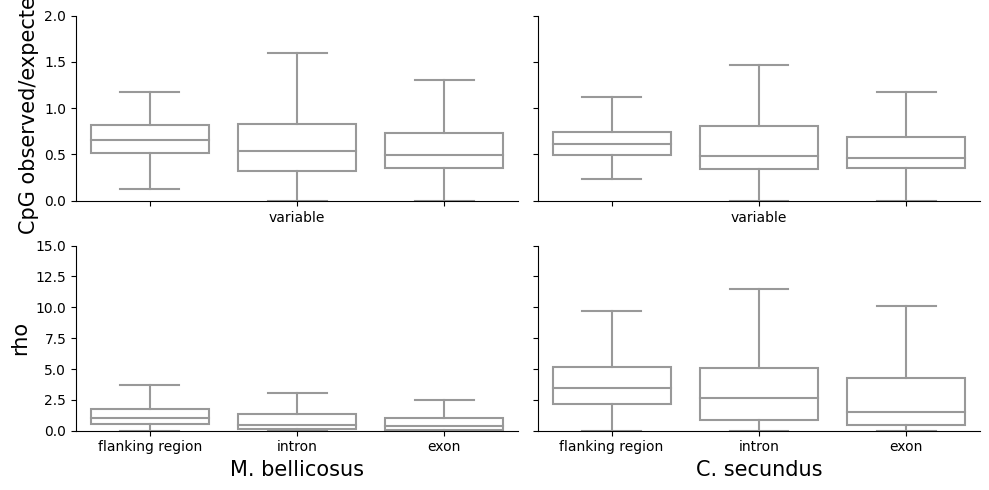

In [28]:
# figure L

fig,((ax, ax1),(ax2,ax3)) = plt.subplots(ncols=2,nrows=2, sharex=True, sharey='row', figsize=(10,5))
mcpg = mm4_Mbel_gene.melt(value_vars=['mean_cpg_flank', 'intron_cpg_oe', 'exon_cpg_oe'])
sns.boxplot(data=mcpg, x='variable', y='value', ax=ax, color='white', fliersize=0)

mrho = mm4_Mbel_gene.melt(value_vars=['mean_rho_flank', 'mean_intron_rho', 'mean_exon_rho'])
sns.boxplot(data=mrho, x='variable', y='value', ax=ax2, color='white', fliersize=0)

ccpg = mm4_Csec_gene.melt(value_vars=['mean_cpg_flank', 'intron_cpg_oe', 'exon_cpg_oe'])
sns.boxplot(data=ccpg, x='variable', y='value', ax=ax1, color='white', fliersize=0)

crho = mm4_Csec_gene.melt(value_vars=['mean_rho_flank', 'mean_intron_rho', 'mean_exon_rho'])
sns.boxplot(data=crho, x='variable', y='value', ax=ax3, color='white', fliersize=0)


ax2.set_xticklabels(['flanking region', "intron", "exon"])

ax2.set_ylabel('rho', size=15)

ax.set_ylabel('CpG observed/expected', size=15)


ax1.set_ylabel('', size=15)
ax3.set_ylabel('', size=15)


ax2.set_xlabel('M. bellicosus', size=15)
ax3.set_xlabel('C. secundus', size=15)


ax.set_ylim(0,2)
ax2.set_ylim(0,15)

sns.despine()
plt.tight_layout()

plt.savefig('./figures/20230922_figL',bbox_inches='tight')
plt.savefig('./figures/20230922_figL.svg',bbox_inches='tight')
plt.savefig('./figures/20230922_figL.pdf',bbox_inches='tight')

plt.show()


## plot

In [35]:
DEdf = pd.read_csv('./Mbel/old_data/20230727_DE_table_with_orthologues_from_elsner2017.tsv', sep='\t', index_col=0)
DEdf = DEdf.dropna(subset=['sgo'])
DEdf.columns = ['GeneID_Mnat', 'DE', 'DE_royal', 'sgo', 'sgo_mbel', 'sgo_mnat',
       'king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
       'orthologues']

DEdf['queen_biased'] = DEdf[['queen_upregulated_vs_king', 'queen_upregulated_vs_majorworker', 'queen_upregulated_vs_minorworker']].sum(axis=1).astype(bool)
DEdf['king_biased'] = DEdf[['king_upregulated_vs_queen', 'king_upregulated_vs_majorworker', 'king_upregulated_vs_minorworker']].sum(axis=1).astype(bool)
DEdf['worker_biased'] = DEdf[['majorworker_upregulated_vs_king', 'majorworker_upregulated_vs_queen', 'minorworker_upregulated_vs_king', 'minorworker_upregulated_vs_queen']].sum(axis=1).astype(bool)
DEdf['male_biased'] = DEdf[['king_upregulated_vs_queen']].sum(axis=1).astype(bool)
DEdf['female_biased'] = DEdf[['queen_upregulated_vs_king']].sum(axis=1).astype(bool)
DEdf['reproduction_biased'] = DEdf[['queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker', 'king_upregulated_vs_minorworker', 'queen_upregulated_vs_minorworker']].sum(axis=1).astype(bool)

DE_sgo = DEdf.loc[DEdf.sgo==True]
mm4_Mbel_gene = mm4_Mbel_gene.reset_index()
DE_Mbel = mm4_Mbel_gene.merge(DE_sgo, left_on='GeneID', right_on='orthologues')
DE_Mbel = DE_Mbel.replace('no_overlap_bin', np.nan)
DE_Mbel.weighted_mean_rho_gene = DE_Mbel.weighted_mean_rho_gene.astype(float)

In [38]:
DE_sgo.loc[DE_sgo.DE==False]

,GeneID_Mnat,DE,DE_royal,sgo,sgo_mbel,sgo_mnat,king_upregulated_vs_queen,majorworker_upregulated_vs_king,majorworker_upregulated_vs_queen,queen_upregulated_vs_king,...,majorworker_upregulated_vs_minorworker,queen_upregulated_vs_minorworker,minorworker_upregulated_vs_queen,orthologues,queen_biased,king_biased,worker_biased,male_biased,female_biased,reproduction_biased
3,Mnat_01289,False,False,True,True,True,False,False,False,False,...,False,False,False,g7976.t1,False,False,False,False,False,False
4,Mnat_01290,False,False,True,True,True,False,False,False,False,...,False,False,False,g7975.t1,False,False,False,False,False,False
11,Mnat_02268,False,False,True,True,True,False,False,False,False,...,False,False,False,g2262.t1,False,False,False,False,False,False
14,Mnat_02271,False,False,True,True,True,False,False,False,False,...,False,False,False,g2255.t1,False,False,False,False,False,False
15,Mnat_02272,False,False,True,True,True,False,False,False,False,...,False,False,False,g2254.t1,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16246,Mnat_17690,False,False,True,True,True,False,False,False,False,...,False,False,False,g1809.t1,False,False,False,False,False,False
16252,Mnat_17696,False,False,True,True,True,False,False,False,False,...,False,False,False,g20110.t1,False,False,False,False,False,False
16257,Mnat_17701,False,False,True,True,True,False,False,False,False,...,False,False,False,g1336.t2,False,False,False,False,False,False
16259,Mnat_17703,False,False,True,True,True,False,False,False,False,...,False,False,False,g16633.t2,False,False,False,False,False,False


In [15]:
DEtypes = ['queen_biased','king_biased','worker_biased', 'male_biased', 'female_biased', 'reproduction_biased', 'DE']

In [40]:
DE_Mbel_melt = DE_Mbel.melt(id_vars=['orthologues', 'GeneID']+DEtypes, value_vars=['gene_cpg_oe','weighted_mean_rho_gene', 'mean_cpg_flank','mean_rho_flank' ])

In [41]:
qb = DE_Mbel_melt.loc[DE_Mbel_melt.queen_biased==True][['GeneID', 'variable', 'value']]
qb['status'] = ['qb' for i in range(qb.shape[0])]

In [42]:
kb = DE_Mbel_melt.loc[DE_Mbel_melt.king_biased==True][['GeneID', 'variable', 'value']]
kb['status'] = ['kb' for i in range(kb.shape[0])]

In [43]:
wb = DE_Mbel_melt.loc[DE_Mbel_melt.worker_biased==True][['GeneID', 'variable', 'value']]
wb['status'] = ['wb' for i in range(wb.shape[0])]

In [44]:
mb = DE_Mbel_melt.loc[DE_Mbel_melt.male_biased==True][['GeneID', 'variable', 'value']]
mb['status'] = ['mb' for i in range(mb.shape[0])]

In [45]:
fb = DE_Mbel_melt.loc[DE_Mbel_melt.female_biased==True][['GeneID', 'variable', 'value']]
fb['status'] = ['fb' for i in range(fb.shape[0])]

In [46]:
rb = DE_Mbel_melt.loc[DE_Mbel_melt.reproduction_biased==True][['GeneID', 'variable', 'value']]
rb['status'] = ['rb' for i in range(rb.shape[0])]

In [47]:
node = DE_Mbel_melt.loc[DE_Mbel_melt.DE==False][['GeneID', 'variable', 'value']]	
node['status'] = ['node' for i in range(node.shape[0])]

In [48]:
Mbel_DE_status = pd.concat([qb, kb, wb,mb,fb,rb, node])

<Axes: xlabel='status', ylabel='value'>

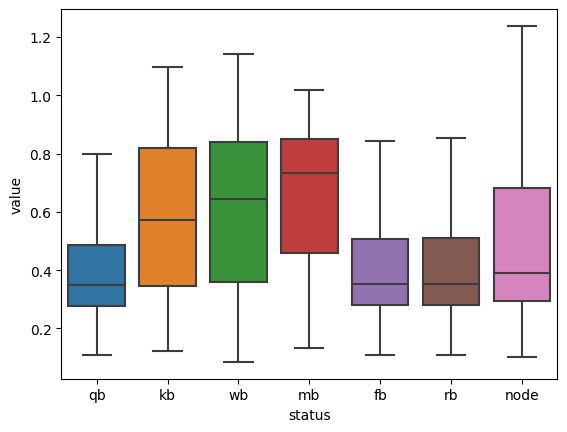

In [49]:
sns.boxplot(data=Mbel_DE_status.loc[Mbel_DE_status.variable=='gene_cpg_oe'], x='status', y='value', fliersize=0)

<Axes: xlabel='status', ylabel='value'>

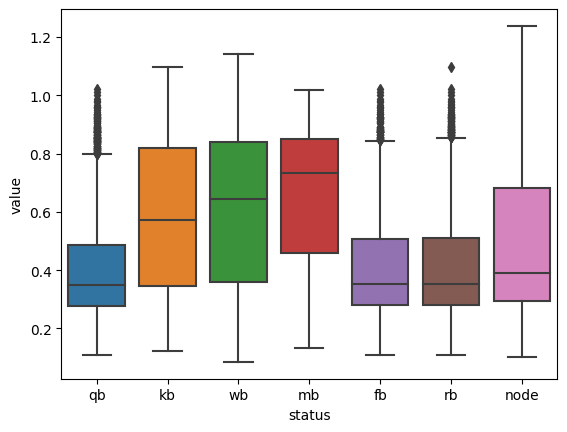

In [50]:
sns.boxplot(data=Mbel_DE_status.loc[Mbel_DE_status.variable=='gene_cpg_oe'], x='status', y='value')

(0.0, 4.0)

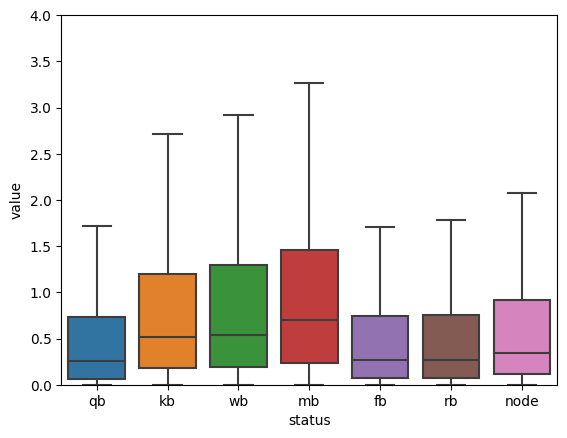

In [51]:
sns.boxplot(data=Mbel_DE_status.loc[Mbel_DE_status.variable=='weighted_mean_rho_gene'], x='status', y='value', fliersize=0)
plt.ylim(0,4)

In [8]:
DE_data = pd.read_csv('./Csec/old_data/DE_data/Queen_up_v_worker.tsv', comment='#', sep='\t')
DE_data.log2FoldChange = [ float(i.replace(',', '.')) for i in DE_data.log2FoldChange]
DE_data['worker_biased'] = DE_data.log2FoldChange>0
DE_data['queen_biased'] = DE_data.log2FoldChange<0
tdf = pd.read_csv('./Csec/old_data/DE_data/DE_ID_list.txt', sep='\t')
tdf = pd.read_csv('./Csec/old_data/DE_data/DE_ID_list.txt', sep='\t')
tdict = {}
for i, k in tdf.iterrows():
    gid_old = str(k.Aliases).split(',')[0]
    if not gid_old  == 'nan':
        if gid_old.startswith('B7P43_'):
            gid_mod = 'Csec_'+gid_old.split('_')[1]
            tdict[gid_mod] = 'GeneID:'+str(k.GeneID)
        else:
            print(k.Aliases)
gids_DE =[] 
for i, k in DE_data.iterrows():
    try:
        gids_DE.append(tdict[k.Csec_geneName])
    except KeyError:
        gids_DE.append(np.nan)

DE_data['GeneID'] = gids_DE

DE_data = DE_data.dropna(subset='GeneID')

DE_csec = mm4_Csec_gene.merge(right=DE_data, left_on='GeneID', right_on='GeneID', how='left')

LTA4H_3
LTA4H_3
CYP6K1_11
CYP6K1_11, CYP6K1_6
RBL1_1
RBL1_1
DHRS11_9
DHRS11_9
DHRS11_9
DHRS11_9
Nif3l1_3
Nif3l1_3
CYP6J1_1
CYP6J1_1
UGT2B19_2
UGT2B19_2
Aldh1a2_2
Aldh1a2_2
UGT2B30_3
UGT2B30_3
UGT2B30_3, Ugt8
AKR1E2_1
AKR1E2_1
ESTF_15
Cg25C
Cg25C
SDR-1_5
SDR-1_5
SDR-1_5
Esd
Esd
Pak4_2
Pak4_2
PPP5C_1
PPP5C_1


In [9]:
DE_csec.worker_biased = DE_csec.worker_biased.replace(True, 'worker-biased')
DE_csec.worker_biased = DE_csec.worker_biased.replace(False, 'queen-biased')
DE_csec.worker_biased = DE_csec.worker_biased.replace(np.nan, 'unbiased')

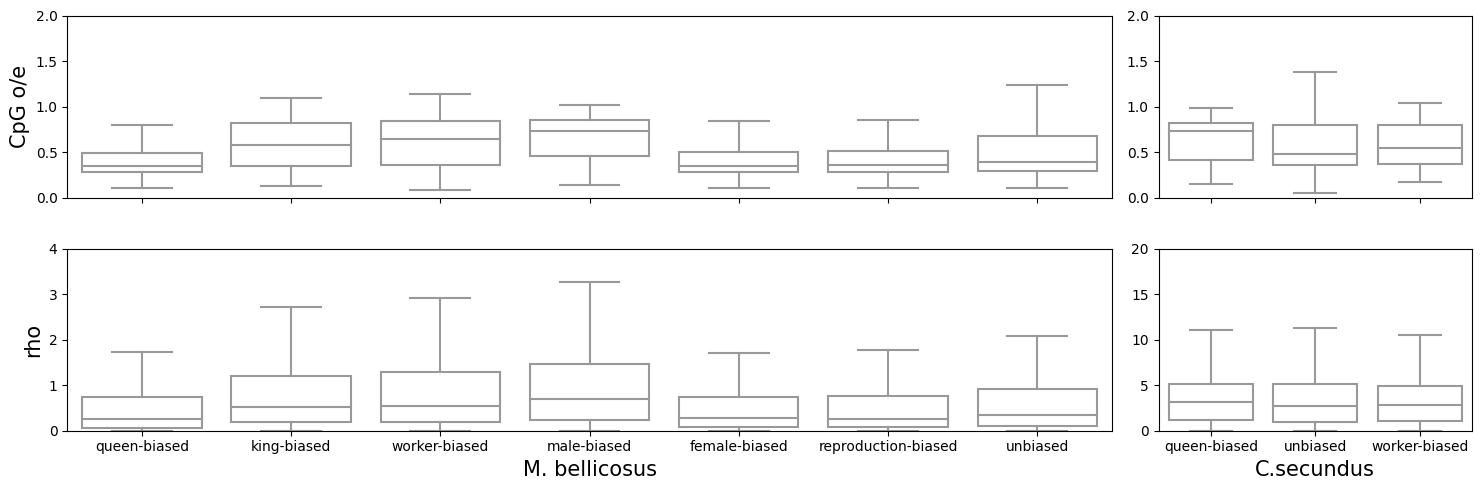

In [46]:
fig, ((ax, ax1),(ax2,ax3)) = plt.subplots(ncols=2, nrows=2, figsize=(15,5), sharex='col',gridspec_kw={'width_ratios':(10,3)})

sns.boxplot(data=Mbel_DE_status.loc[Mbel_DE_status.variable=='gene_cpg_oe'], x='status', y='value', fliersize=0, ax=ax, color="white")



sns.boxplot(data=Mbel_DE_status.loc[Mbel_DE_status.variable=='weighted_mean_rho_gene'], x='status', y='value', fliersize=0, ax=ax2, color="white")
ax2.set_xticklabels(['queen-biased', 'king-biased', 'worker-biased', 'male-biased', 'female-biased', 'reproduction-biased', 'unbiased'])
ax.set_xlabel('')
ax1.set_xlabel('')



sns.boxplot(data=DE_csec, x='worker_biased', y='gene_cpg_oe', fliersize=0, ax=ax1, color="white")

sns.boxplot(data=DE_csec, x='worker_biased', y='weighted_mean_rho_gene', fliersize=0, ax=ax3, color="white")

ax.set_ylabel('CpG o/e',size=15)
ax1.set_ylabel('',size=15)
ax3.set_ylabel('',size=15)

ax.set_ylim(0,2)
ax1.set_ylim(0,2)


ax3.set_ylim(0,20)
ax2.set_ylim(0,4)


ax2.set_ylabel('rho',size=15)
ax2.set_xlabel('M. bellicosus', size=15)
ax3.set_xlabel('C.secundus', size=15)
ax1.set_xlabel(' ', size=15)

plt.savefig('./figures/20230922_figH_no_hl_cpg.png',bbox_inches='tight')
plt.savefig('./figures/20230922_figH_no_hl_cpg.svg',bbox_inches='tight')
plt.savefig('./figures/20230922_figH_no_hl_cpg.pdf',bbox_inches='tight')


plt.tight_layout()
plt.show()

In [208]:
mm4_Mbel_gene.columns

Index(['level_0', 'index', 'GeneID', 'Unnamed: 0', 'ID', 'gene_cpg_e',
       'gene_cpg_o', 'gene_cpg_oe', 'scaffold', 'featuretype', 'Start_pos',
       'End_pos', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'mean_rho_flank', 'mean_cpg_flank', 'mean_intron_rho', 'mean_exon_rho',
       'intron_cpg_oe', 'exon_cpg_oe'],
      dtype='object')

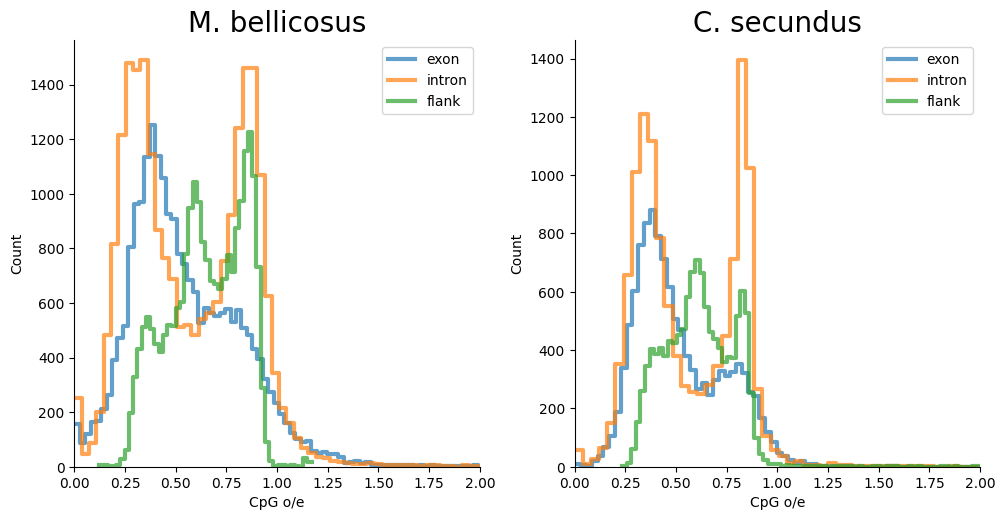

In [24]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.histplot(mm4_Mbel_gene.exon_cpg_oe, ax=ax,element="step", alpha=0.7, label='exon',lw=3, fill=False)
sns.histplot(mm4_Mbel_gene.intron_cpg_oe, ax=ax,element="step", alpha=0.7, label='intron',lw=3, fill=False)
sns.histplot(mm4_Mbel_gene.mean_cpg_flank, ax=ax,element="step", alpha=0.7, label='flank',lw=3, fill=False)
ax.set_xlim(0,2.0)
ax.set_xlabel('CpG o/e')

sns.histplot(mm4_Csec_gene.exon_cpg_oe, ax=ax1,element="step", alpha=0.7, label='exon',lw=3, fill=False)
sns.histplot(mm4_Csec_gene.intron_cpg_oe, ax=ax1,element="step", alpha=0.7, label='intron',lw=3, fill=False)
sns.histplot(mm4_Csec_gene.mean_cpg_flank, ax=ax1,element="step", alpha=0.7, label='flank',lw=3, fill=False)
ax.set_xlim(0,2.0)
ax.set_xlabel('CpG o/e')
ax1.set_xlabel('CpG o/e')

ax.legend()


sns.despine()
ax1.legend()

plt.tight_layout()
ax.set_title('M. bellicosus', size=20)
ax1.set_title('C. secundus', size=20)
ax1.set_xlim(0,2.0)


plt.savefig('./figures/20230922_figSF.png',bbox_inches='tight')
plt.savefig('./figures/20230922_figSF.svg',bbox_inches='tight')
plt.savefig('./figures/20230922_figSF.pdf',bbox_inches='tight')
     

plt.show()

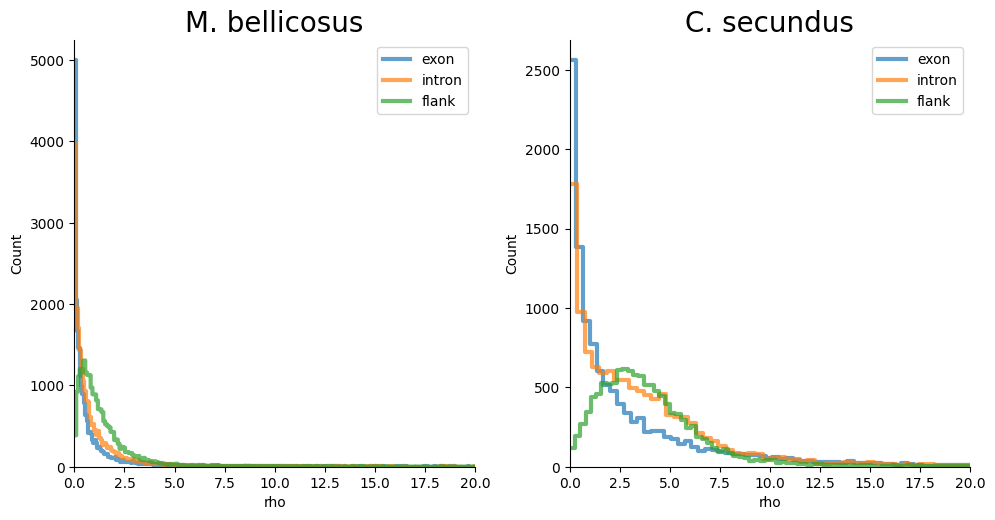

In [25]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.histplot(mm4_Mbel_gene.mean_exon_rho, ax=ax,element="step", alpha=0.7, label='exon',lw=3, fill=False)
sns.histplot(mm4_Mbel_gene.mean_intron_rho, ax=ax,element="step", alpha=0.7, label='intron',lw=3, fill=False)
sns.histplot(mm4_Mbel_gene.mean_rho_flank, ax=ax,element="step", alpha=0.7, label='flank',lw=3, fill=False)
#ax.set_xlim(0,2.0)
ax.set_xlabel('Recombinations/Kb')

sns.histplot(mm4_Csec_gene.mean_exon_rho, ax=ax1,element="step", alpha=0.7, label='exon',lw=3, fill=False)
sns.histplot(mm4_Csec_gene.mean_intron_rho, ax=ax1,element="step", alpha=0.7, label='intron',lw=3, fill=False)
sns.histplot(mm4_Csec_gene.mean_rho_flank, ax=ax1,element="step", alpha=0.7, label='flank',lw=3, fill=False)
ax.set_xlim(0,20)
ax.set_xlabel('rho')
ax1.set_xlabel('rho')

ax.legend()


sns.despine()
ax1.legend()

plt.tight_layout()
ax.set_title('M. bellicosus', size=20)
ax1.set_title('C. secundus', size=20)
ax1.set_xlim(0,20)


plt.savefig('./figures/20230922_rho_dist.png',bbox_inches='tight')
plt.savefig('./figures/20230922_rho_dist.svg',bbox_inches='tight')
plt.savefig('./figures/20230922_rho_dist.pdf',bbox_inches='tight')
     

plt.show()

In [145]:
set(Mbel_DE_status.variable)

{'gene_cpg_oe', 'mean_cpg_flank', 'mean_rho_flank', 'weighted_mean_rho_gene'}

In [106]:
len(DEtypes)

6

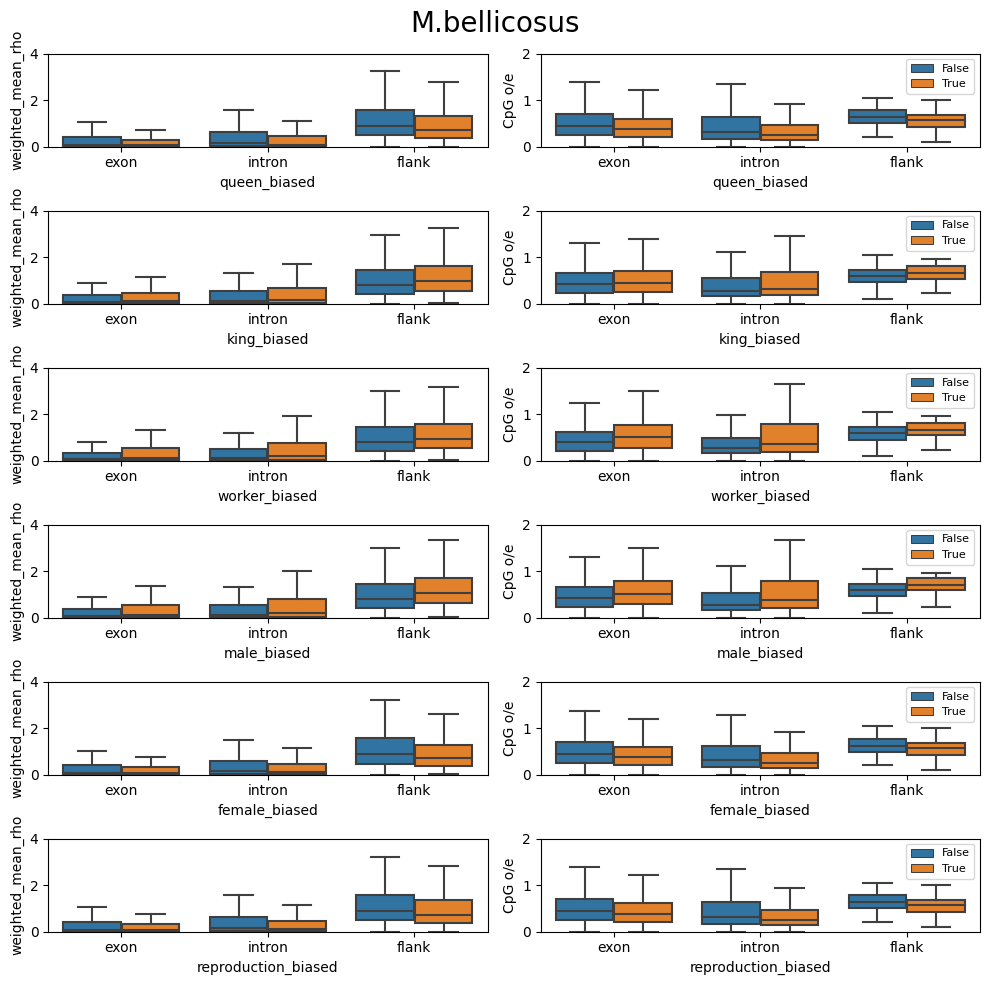

In [81]:
fig, axes = plt.subplots(ncols=2, nrows=6, figsize=(10, 10), sharex=False, sharey='col')
for i, k  in enumerate(DEtypes):
    #ss_de = DE_Mbel_melt.loc[DE_Mbel_melt[k]==True]
    ss_de = DE_Mbel_melt

    sns.boxplot(data=ss_de.loc[ss_de.variable.isin(['weighted_mean_rho_gene','mean_rho_flank'])].loc[ss_de.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', hue=k, fliersize=0, ax= axes[i,0])
    sns.boxplot(data=ss_de.loc[ss_de.variable.isin(['gene_cpg_oe','mean_cpg_flank'])].loc[ss_de.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', hue=k, fliersize=0, ax=axes[i,1])
    #sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,0])
    #sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,1]) 
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='exon'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'red'}, label='exon')
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='intron'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'blue', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'blue'}, label='intron')
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='gene'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'purple', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'purple'}, label='gene')
    
    axes[i,1].legend(fontsize=8)
    axes[i,0].get_legend().remove()
    axes[i,0].set_ylim(0,4)
    axes[i,1].set_ylim(0,2)
    axes[i,0].set_xlabel(k)

    axes[i,0].set_ylabel('weighted_mean_rho')
    axes[i,1].set_ylabel('CpG o/e')
    axes[i,1].set_xlabel(k)
    #axes[i,2].set_xlabel(k)
    #axes[i,2].set_ylim(0,10)
    #axes[i,2].set_xlim(0,10)
    #axes[i,2].legend(fontsize=8)
plt.suptitle('M.bellicosus', fontsize=20)
#plt.savefig('./figures/20230810_Mbel_DE_panel.png',bbox_inches='tight')
#plt.savefig('./figures/20230810_Mbel_DE_panel.svg',bbox_inches='tight')
plt.tight_layout()
plt.show()

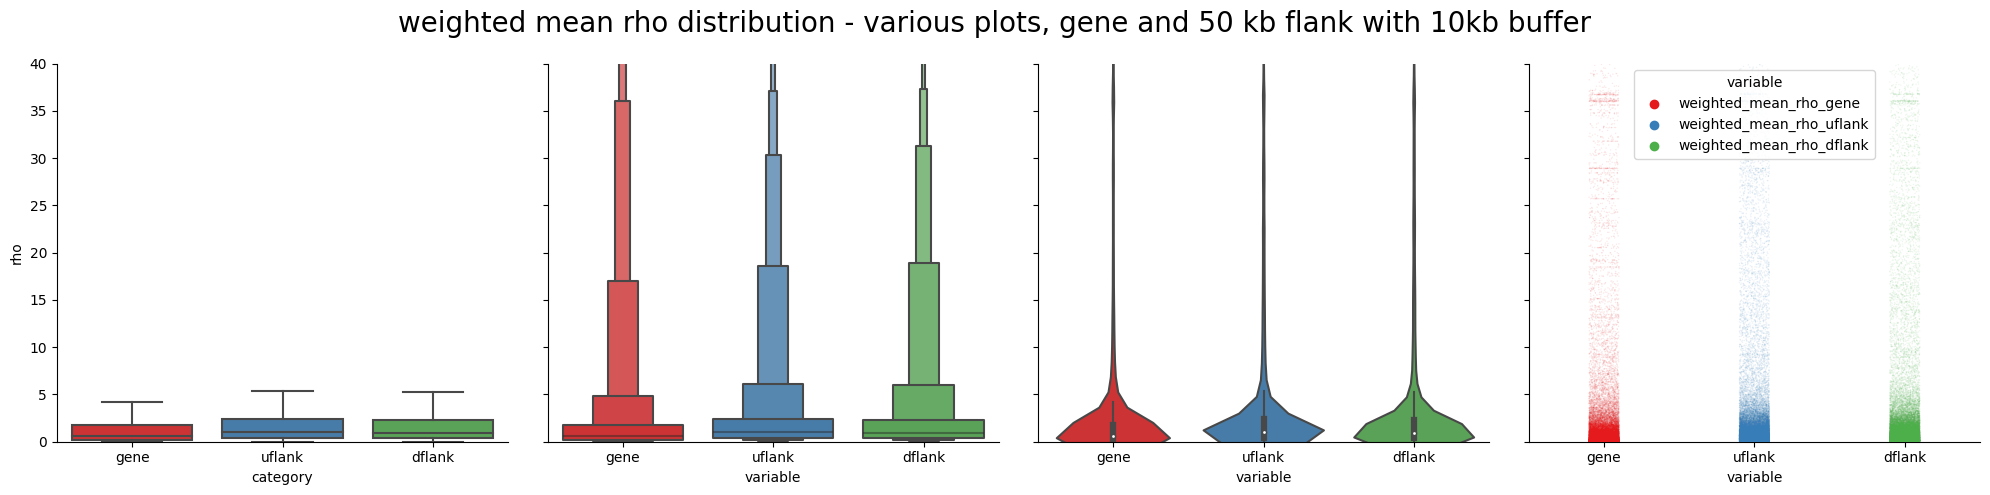

In [29]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(ncols=4, nrows=1, figsize=(20,5), sharey=True, sharex=True)
sns.boxplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)
sns.boxenplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax1)
sns.violinplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax2)
sns.stripplot(data=rho_chunks_dfmelt, y="value",x='variable', hue='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax3, alpha=0.1, s=1)


ax.set_xticklabels(['gene', 'uflank', 'dflank'])
ax.set_ylabel('rho')
ax1.set_ylabel(' ')
ax2.set_ylabel(' ')
ax3.set_ylabel(' ')
ax.set_xlabel('category')
ax.set_ylim(0,40)

fig.suptitle('weighted mean rho distribution - various plots, gene and 50 kb flank with 10kb buffer', size=20)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/20230810_Mbel_rho_boxplot_and_alternatives_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_boxplot_and_alternatives_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')
plt.show()

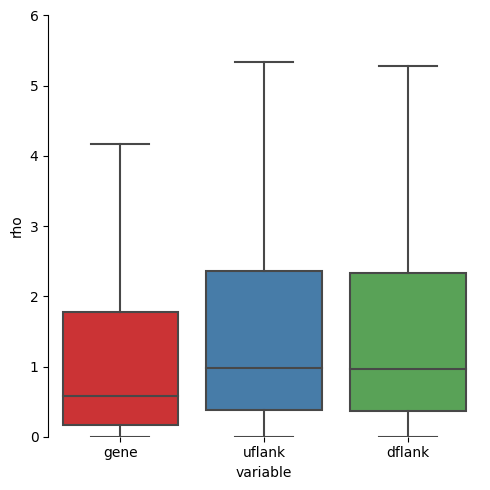

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
sns.boxplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)


ax.set_xticklabels(['gene', 'uflank', 'dflank'])
ax.set_ylabel('rho')

ax.set_ylim(0,6)

plt.tight_layout()
sns.despine(bottom=True)
plt.savefig('./figures/20230810_Mbel_rho_boxplot_no_outlier_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_boxplot_no_outlier_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')
plt.show()

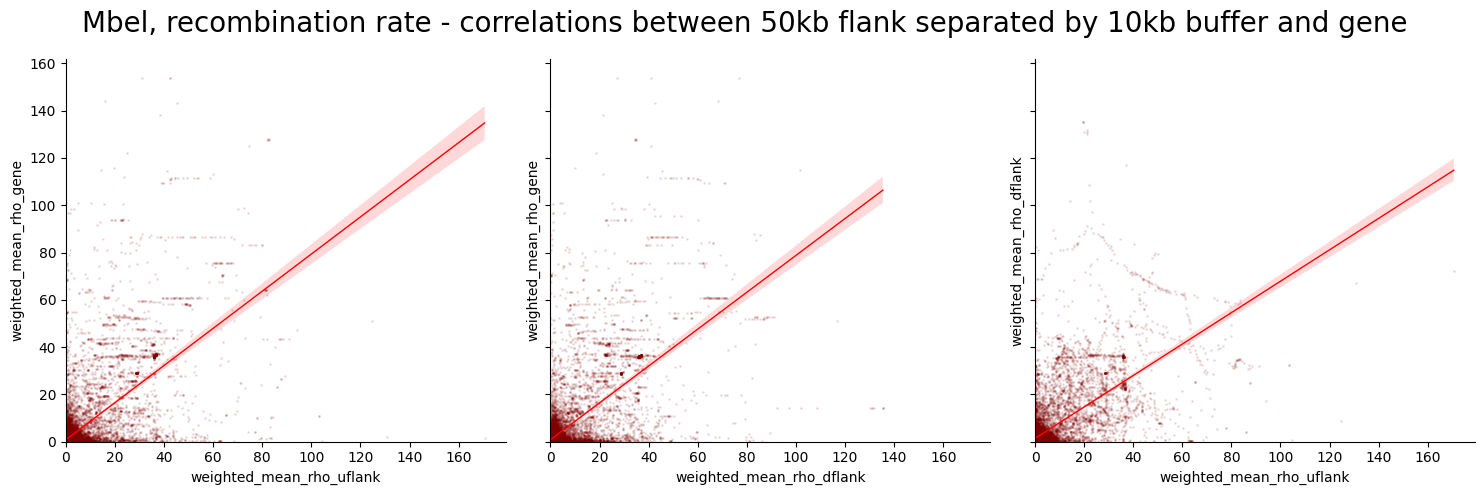

In [32]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True, sharex=True)

sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_gene", ax=ax, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_dflank", y="weighted_mean_rho_gene", ax=ax1, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_dflank", ax=ax2, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )

ax.set_xlim(0,)
ax.set_ylim(0,)

fig.suptitle("Mbel, recombination rate - correlations between 50kb flank separated by 10kb buffer and gene", size=20)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/20230810_Mbel_rho_correlations_between_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_correlations_between_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')

plt.show()

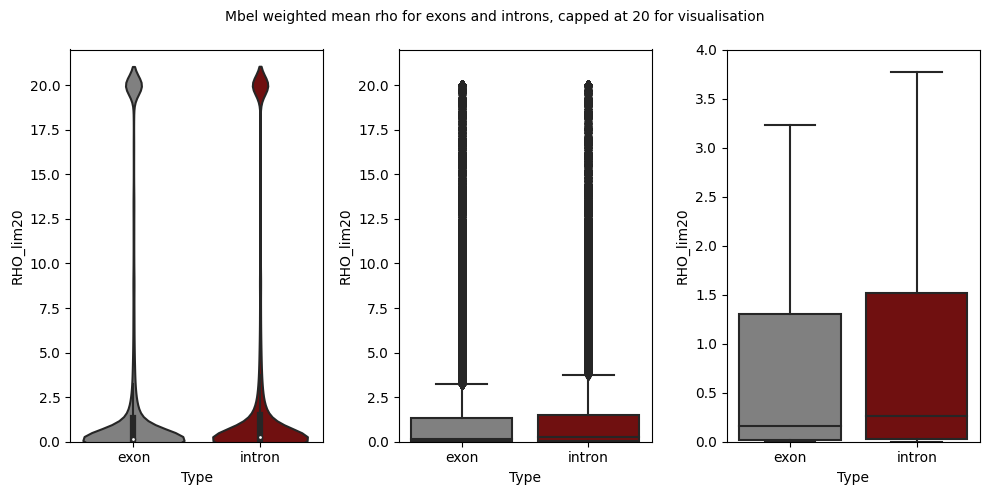

In [45]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(10,5), sharey=False)

sns.violinplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax, palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax1,palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax2, fliersize=0,palette=['grey', 'maroon'])

ax.set_ylim(0,22)
ax1.set_ylim(0,22)
fig.suptitle('Mbel weighted mean rho for exons and introns, capped at 20 for visualisation', size=10)
ax2.set_ylim(0,4)
plt.tight_layout()
plt.savefig('./figures/20230810_Mbel_rho_boxplot_and_alternatives_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_boxplot_and_alternatives_exon_and_introns.svg',bbox_inches='tight')
plt.show()

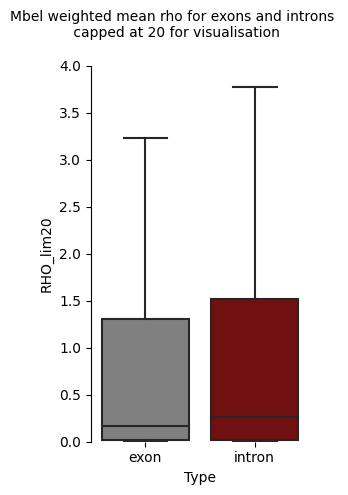

In [48]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,5), sharey=False)


sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax, fliersize=0,palette=['grey', 'maroon'])

ax.set_ylim(0,4)

fig.suptitle('Mbel weighted mean rho for exons and introns \n capped at 20 for visualisation', size=10)

plt.tight_layout()
plt.savefig('./figures/20230810_Mbel_rho_boxplot_no_outliers_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_boxplot_no_outliers_exon_and_introns.svg',bbox_inches='tight')
sns.despine(bottom=True)
plt.show()

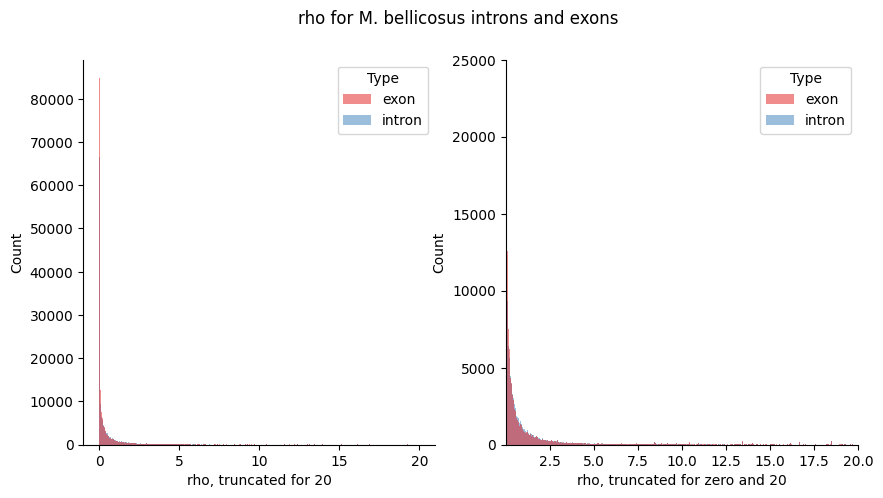

In [53]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="Type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax)
#x.set_xlim(0,2)
fig.suptitle('rho for M. bellicosus introns and exons')
ax.set_xlabel('rho, truncated for 20')

sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="Type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax1)
ax1.set_xlim(0.001,20)
ax1.set_ylim(0,25000)
ax1.set_xlabel('rho, truncated for zero and 20')

plt.savefig('./figures/20230810_Mbel_rho_dist_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_dist_exon_and_introns.svg',bbox_inches='tight')
sns.despine()
plt.show()

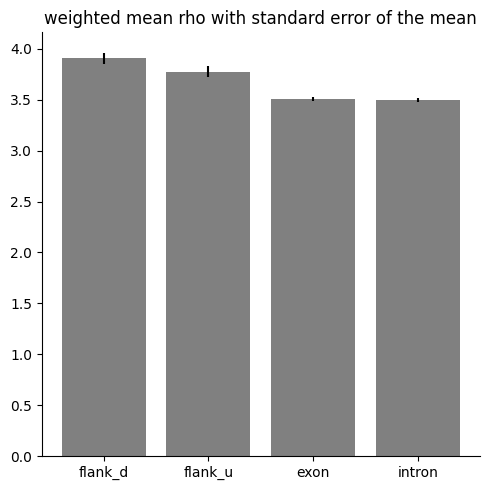

In [55]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
ax.bar(height = [3.909249,3.777496,3.508157,3.498127 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.054706,0.053719,0.021512,0.022177], color='grey')
#ax1.bar(height = [3.909249,3.909249,3.508157,3.498127 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [11.521898,11.547933,10.836931,10.512917], color='grey')

ax.set_title("weighted mean rho with standard error of the mean")
#ax1.set_title("weighted mean rho with standard deviation")
sns.despine()
plt.tight_layout()
ax.set_ylim(0,)
plt.savefig('./figures/20230810_Mbel_rho_barplot_with_sem_50kb_flank_10kbbuffer_and_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_barplot_with_sem_50kb_flank_10kbbuffer_and_exon_and_introns.svg',bbox_inches='tight')

plt.show()

In [58]:
fd = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_dflank' ]['value'].dropna()
fu = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_uflank' ]['value'].dropna()
ex = rho_chunks_exin_df.loc[rho_chunks_exin_df.Type =='exon']['RHO'].dropna()
intr = rho_chunks_exin_df.loc[rho_chunks_exin_df.Type =='intron']['RHO'].dropna()

thsd = scipy.stats.tukey_hsd(fd, fu, ex, intr)

print(thsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.028     0.989    -0.197     0.253
 (0 - 2)      0.401     0.000     0.233     0.569
 (0 - 3)      0.411     0.000     0.242     0.580
 (1 - 0)     -0.028     0.989    -0.253     0.197
 (1 - 2)      0.373     0.000     0.205     0.541
 (1 - 3)      0.383     0.000     0.214     0.552
 (2 - 0)     -0.401     0.000    -0.569    -0.233
 (2 - 1)     -0.373     0.000    -0.541    -0.205
 (2 - 3)      0.010     0.988    -0.068     0.088
 (3 - 0)     -0.411     0.000    -0.580    -0.242
 (3 - 1)     -0.383     0.000    -0.552    -0.214
 (3 - 2)     -0.010     0.988    -0.088     0.068



# Csec - Rho

## load data

In [24]:
#load data
rho_chunks_df= pd.read_csv('./Csec/20230810_Csec_rho_per_gene_and_50kbflank_with_10kbbuffer.tsv', sep='\t')
rho_chunks_dfmelt = rho_chunks_df.melt(id_vars=['idstring', 'scaffold'], value_vars=['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank',] )

rho_chunks_exin_df= pd.read_csv('./Csec/rho_per_gene/20230717_Csec_rho_exons_and_introns.tsv', sep='\t', index_col=0)
rho_chunks_exin_df.columns =['scaffold', 'source', 'Type', 'start', 'stop', 'n', 'strand', 'n2',
       'idstring', 'scaffold2', 'RHO']
rho_chunks_exin_df.RHO = rho_chunks_exin_df.RHO.replace('no_overlap_bin', np.nan).astype(float)

## plot

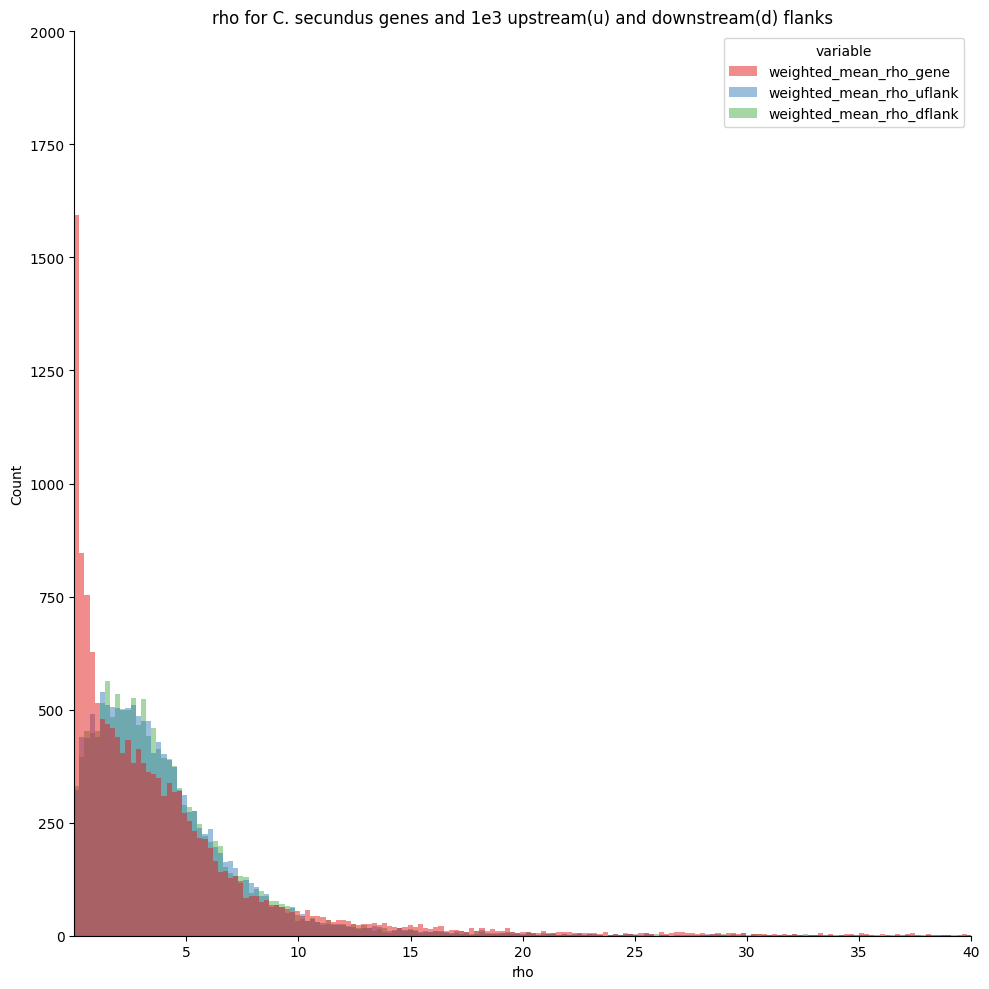

In [97]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
sns.histplot(data=rho_chunks_dfmelt, x="value", hue="variable",linewidth=0, palette = ['#e41a1c','#377eb8','#4daf4a'])

ax.set_xlim(0.01,40)
ax.set_ylim(0.00,2000)
ax.set_title('rho for C. secundus genes and 1e3 upstream(u) and downstream(d) flanks')
ax.set_xlabel('rho')

sns.despine()
plt.tight_layout()
plt.savefig('./figures/20230810_Csec_rho_dist_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_dist_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')
plt.show()

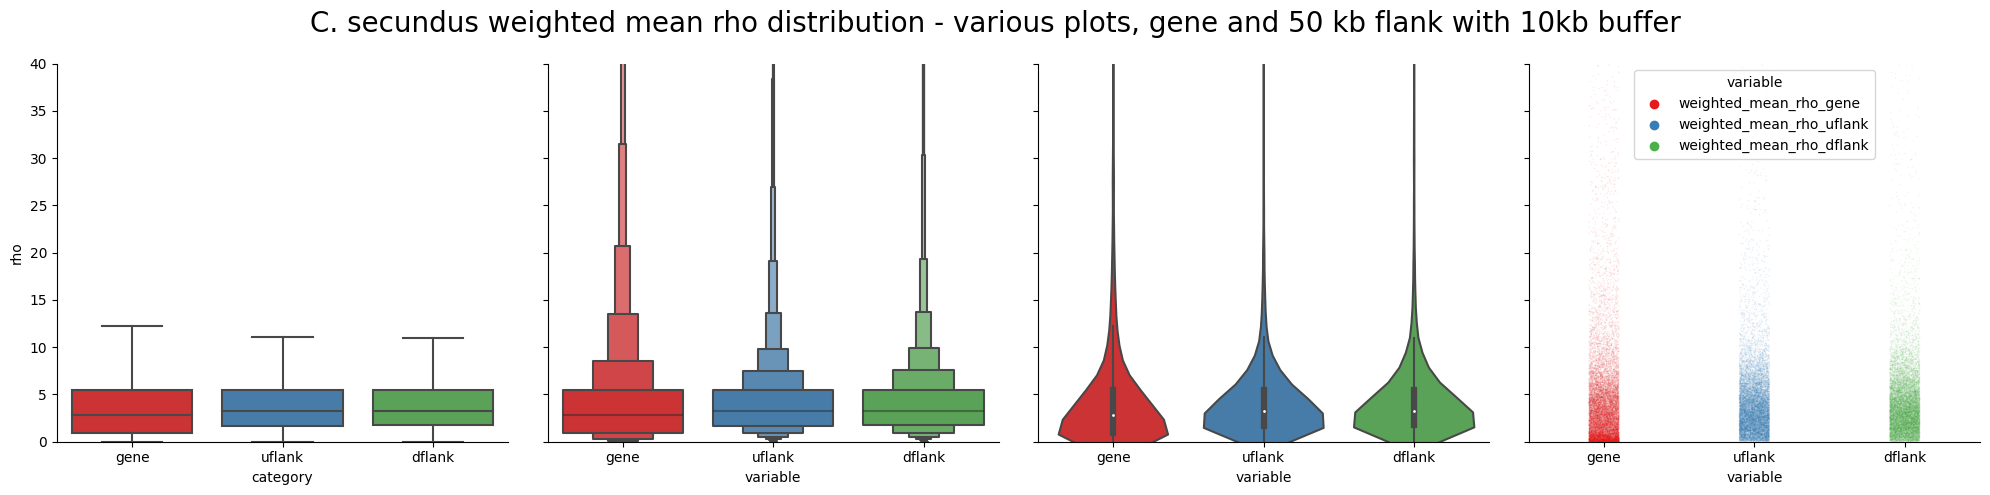

In [98]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(ncols=4, nrows=1, figsize=(20,5), sharey=True, sharex=True)
sns.boxplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)
sns.boxenplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax1)
sns.violinplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax2)
sns.stripplot(data=rho_chunks_dfmelt, y="value",x='variable', hue='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax3, alpha=0.1, s=1)


ax.set_xticklabels(['gene', 'uflank', 'dflank'])
ax.set_ylabel('rho')
ax1.set_ylabel(' ')
ax2.set_ylabel(' ')
ax3.set_ylabel(' ')
ax.set_xlabel('category')
ax.set_ylim(0,40)

fig.suptitle('C. secundus weighted mean rho distribution - various plots, gene and 50 kb flank with 10kb buffer', size=20)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/20230810_Csec_rho_boxplot_and_alternatives_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_boxplot_and_alternatives_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')
plt.show()

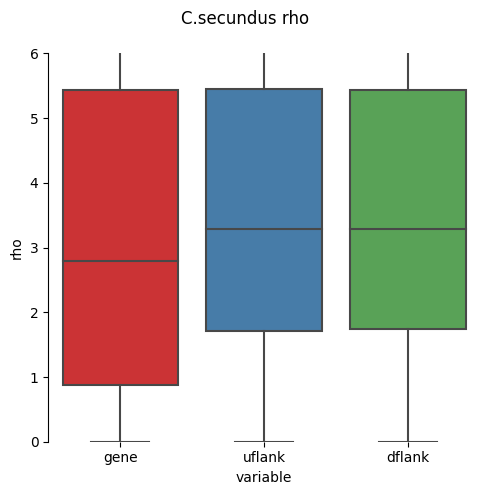

In [100]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
sns.boxplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)


ax.set_xticklabels(['gene', 'uflank', 'dflank'])
ax.set_ylabel('rho')
fig.suptitle('C.secundus rho')
ax.set_ylim(0,6)

plt.tight_layout()
sns.despine(bottom=True)
plt.savefig('./figures/20230810_Csec_rho_boxplot_no_outlier_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_boxplot_no_outlier_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')
plt.show()

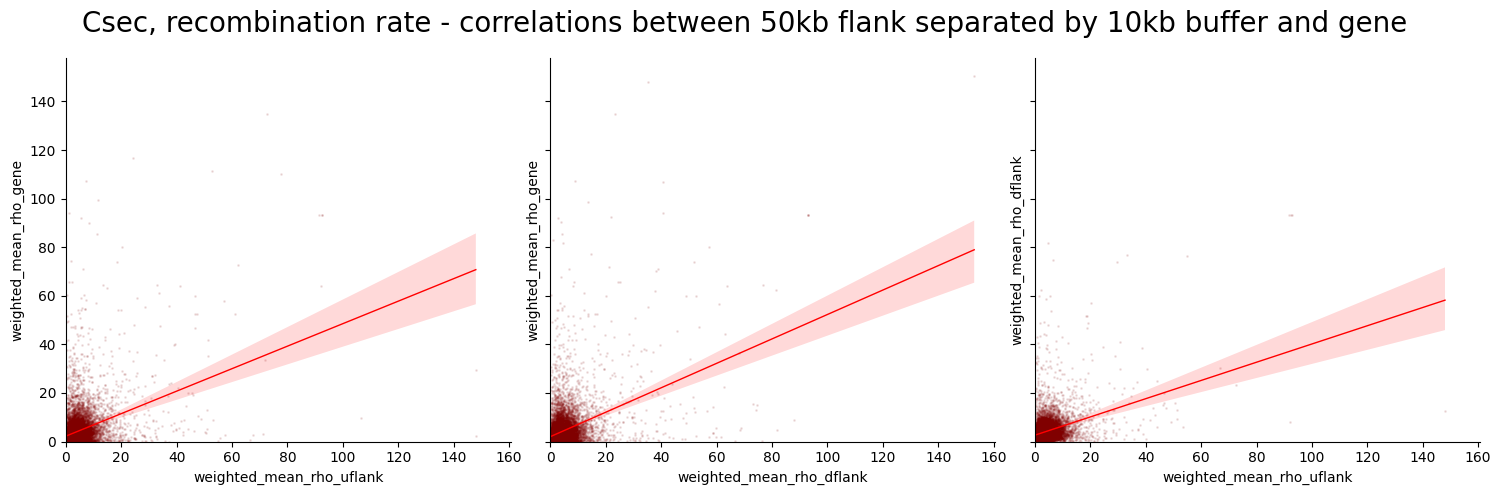

In [101]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True, sharex=True)

sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_gene", ax=ax, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_dflank", y="weighted_mean_rho_gene", ax=ax1, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_dflank", ax=ax2, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )

ax.set_xlim(0,)
ax.set_ylim(0,)

fig.suptitle("Csec, recombination rate - correlations between 50kb flank separated by 10kb buffer and gene", size=20)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/20230810_Csec_rho_correlations_between_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_correlations_between_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')

plt.show()

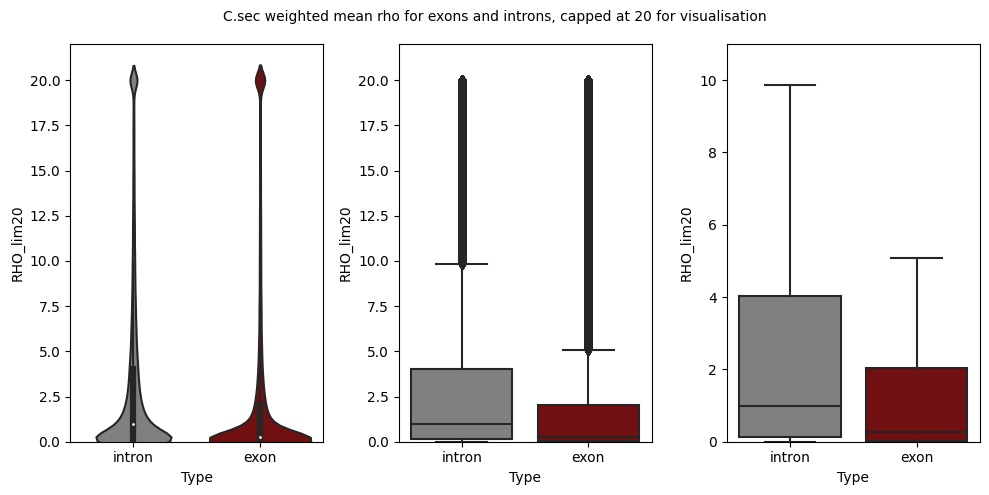

In [106]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(10,5), sharey=False)

sns.violinplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax, palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax1,palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax2, fliersize=0,palette=['grey', 'maroon'])

ax.set_ylim(0,22)
ax1.set_ylim(0,22)
fig.suptitle('C.sec weighted mean rho for exons and introns, capped at 20 for visualisation', size=10)
ax2.set_ylim(0,11)
plt.tight_layout()
plt.savefig('./figures/20230810_Csec_rho_boxplot_and_alternatives_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_boxplot_and_alternatives_exon_and_introns.svg',bbox_inches='tight')
plt.show()

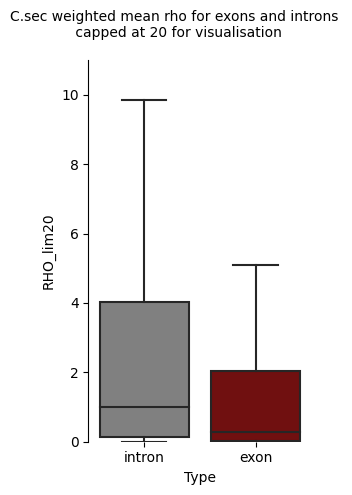

In [107]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,5), sharey=False)

sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax, fliersize=0,palette=['grey', 'maroon'])

ax.set_ylim(0,11)

fig.suptitle('C.sec weighted mean rho for exons and introns \n capped at 20 for visualisation', size=10)

plt.tight_layout()
plt.savefig('./figures/20230810_Csec_rho_boxplot_no_outliers_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_boxplot_no_outliers_exon_and_introns.svg',bbox_inches='tight')
sns.despine(bottom=True)
plt.show()

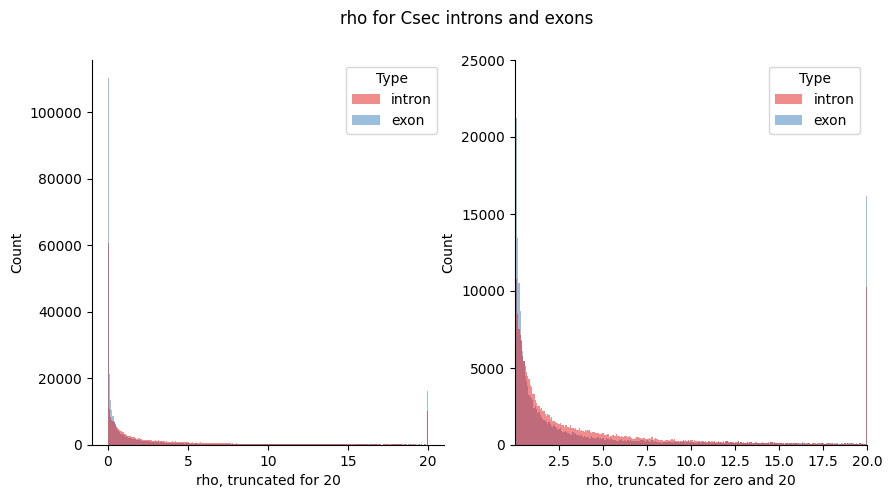

In [108]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="Type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax)
#x.set_xlim(0,2)
fig.suptitle('rho for Csec introns and exons')
ax.set_xlabel('rho, truncated for 20')

sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="Type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax1)
ax1.set_xlim(0.001,20)
ax1.set_ylim(0,25000)
ax1.set_xlabel('rho, truncated for zero and 20')

plt.savefig('./figures/20230810_Csec_rho_dist_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_dist_exon_and_introns.svg',bbox_inches='tight')
sns.despine()
plt.show()

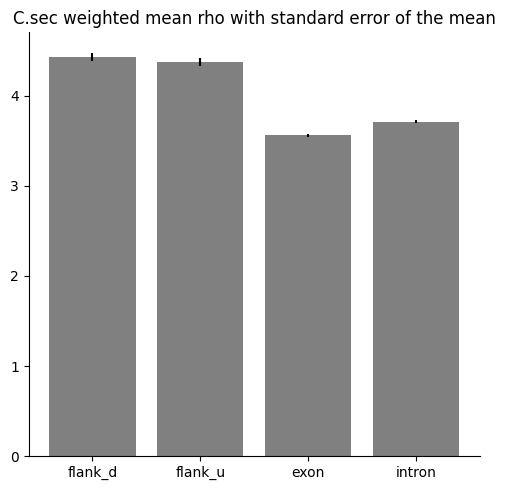

In [189]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
ax.bar(height = [4.432077,4.373883, 3.558582,3.711299 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.046994,0.045769,0.017638,0.014387], color='grey')
#ax1.bar(height = [4.457875,4.463503, 3.558582,3.711299 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [9.954115,10.160580,9.801586,7.556328], color='grey')

ax.set_title("C.sec weighted mean rho with standard error of the mean")

sns.despine()
plt.tight_layout()
ax.set_ylim(0,)

plt.savefig('./figures/20230810_Csec_rho_barplot_with_sem_50kb_flank_10kbbuffer_and_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_barplot_with_sem_50kb_flank_10kbbuffer_and_exon_and_introns.svg',bbox_inches='tight')

plt.show()

In [113]:
fd = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_dflank' ]['value'].dropna()
fu = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_uflank' ]['value'].dropna()
ex = rho_chunks_exin_df.loc[rho_chunks_exin_df.Type =='exon']['RHO'].dropna()
intr = rho_chunks_exin_df.loc[rho_chunks_exin_df.Type =='intron']['RHO'].dropna()

thsd = scipy.stats.tukey_hsd(fd, fu, ex, intr)
print(thsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.058     0.945    -0.212     0.328
 (0 - 2)      0.873     0.000     0.679     1.068
 (0 - 3)      0.721     0.000     0.525     0.916
 (1 - 0)     -0.058     0.945    -0.328     0.212
 (1 - 2)      0.815     0.000     0.620     1.010
 (1 - 3)      0.663     0.000     0.467     0.858
 (2 - 0)     -0.873     0.000    -1.068    -0.679
 (2 - 1)     -0.815     0.000    -1.010    -0.620
 (2 - 3)     -0.153     0.000    -0.211    -0.094
 (3 - 0)     -0.721     0.000    -0.916    -0.525
 (3 - 1)     -0.663     0.000    -0.858    -0.467
 (3 - 2)      0.153     0.000     0.094     0.211



# Mbel-CpG

# Csec-CpG

In [23]:
Csec_CpG_gene_and_flank = pd.read_csv( './Csec/20230810_Csec_CpG_per_gene_and_50kbflank_10kbbuffer.tsv', sep='\t', index_col=0)
Csec_CpG_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Csec/20230717_Csec_CpG_exons_and_introns.tsv', sep='\t', index_col=0)

In [37]:
rho_chunks_exin_df

,scaffold,source,Type,start,stop,n,strand,n2,idstring,scaffold2,RHO
0,,,,,,,,,,,
511495,NW_019731994.1,.,intron,416800,421167,.,+,.,Parent=rna-XM_023857401.2,NEVH01013973.1,5.475161
511496,NW_019731994.1,Gnomon,exon,421168,421270,.,+,.,ID=exon-XM_023857401.2-9;Parent=rna-XM_0238574...,NEVH01013973.1,3.832550
511498,NW_019731994.1,.,intron,421271,422203,.,+,.,Parent=rna-XM_023857401.2,NEVH01013973.1,1.480505
511499,NW_019731994.1,Gnomon,exon,422204,422499,.,+,.,ID=exon-XM_023857401.2-10;Parent=rna-XM_023857...,NEVH01013973.1,3.815746
511501,NW_019731994.1,.,intron,422500,423379,.,+,.,Parent=rna-XM_023857401.2,NEVH01013973.1,8.133196
...,...,...,...,...,...,...,...,...,...,...,...
768548,NW_019739943.1,Gnomon,exon,1063378,1063551,.,-,.,ID=exon-XM_033754500.1-14;Parent=rna-XM_033754...,NEVH01021922.1,14.823760
768550,NW_019739943.1,.,intron,1063552,1082684,.,-,.,Parent=rna-XM_033754500.1,NEVH01021922.1,5.716653
768551,NW_019739943.1,Gnomon,exon,1082685,1082816,.,-,.,ID=exon-XM_033754500.1-13;Parent=rna-XM_033754...,NEVH01021922.1,38.055080


In [39]:
Csec_exin = pd.merge(left=Csec_CpG_exon_and_intron, right=rho_chunks_exin_df, left_on=['ID','featuretype'], right_on=['idstring','Type'])

In [40]:
# generating the intron positions with Genometools has left the IDstring somewhat sparse, only denoting parent RNA.
# here i use the richer ID-string of the exons to link parent-RNA to the genebank ID

ID_dict = {}
for i in Csec_exin.loc[Csec_exin.featuretype=='exon'].ID:
    idfields = i.split(';')
    idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
    ID_dict[idict['Parent']] = idict['Dbxref']


def extract_id(idstring, idtype = 'Dbxref', ID_dict=False):
    if ID_dict == False:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        return idict[idtype].split(',')[0]
    else:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        try:
            return idict[idtype].split(',')[0]
        except KeyError:
            return ID_dict[idict['Parent']].split(',')[0]
            

In [41]:
Csec_gene_and_flank['GeneID'] = [extract_id(i) for i in Csec_gene_and_flank.ID]

In [25]:
Csec_gene_and_flank = pd.merge(left=rho_chunks_df, right=Csec_CpG_gene_and_flank, left_on='idstring', right_on='ID')

In [42]:
Csec_exin['GeneID'] = [extract_id(i, ID_dict=ID_dict) for i in Csec_exin.ID]

In [46]:
Csec_exin.ID[0]

'ID=exon-XM_023864154.2-6;Parent=rna-XM_023864154.2;Dbxref=GeneID:111871218,Genbank:XM_023864154.2;gbkey=mRNA;gene=LOC111871218;product=uncharacterized LOC111871218%2C transcript variant X1;transcript_id=XM_023864154.2'

In [52]:
DE_data.Csec_geneName

0       Csec_G08529
1       Csec_G08558
2       Csec_G10175
3       Csec_G10405
4       Csec_G10411
           ...     
1806    Csec_G05159
1807    Csec_G05306
1808    Csec_G05317
1809    Csec_G06487
1810    Csec_G07846
Name: Csec_geneName, Length: 1811, dtype: object

In [59]:
[ str(i) for i in DE_data.Csec_geneName if str(i).startswith('Csec_G')]

['Csec_G08529',
 'Csec_G08558',
 'Csec_G10175',
 'Csec_G10405',
 'Csec_G10411',
 'Csec_G11924',
 'Csec_G11926',
 'Csec_G12414',
 'Csec_G12415',
 'Csec_G12693',
 'Csec_G12695',
 'Csec_G12698',
 'Csec_G14806',
 'Csec_G14807',
 'Csec_G15120',
 'Csec_G16260',
 'Csec_G16265',
 'Csec_G08751',
 'Csec_G17387',
 'Csec_G18162',
 'Csec_G18346',
 'Csec_G01621',
 'Csec_G01622',
 'Csec_G01623',
 'Csec_G08756',
 'Csec_G03370',
 'Csec_G03390',
 'Csec_G04781',
 'Csec_G04784',
 'Csec_G06821',
 'Csec_G06830',
 'Csec_G09368',
 'Csec_G10723',
 'Csec_G11359',
 'Csec_G11360',
 'Csec_G13267',
 'Csec_G13971',
 'Csec_G14850',
 'Csec_G16611',
 'Csec_G17079',
 'Csec_G17718',
 'Csec_G01756',
 'Csec_G01764',
 'Csec_G10951',
 'Csec_G02647',
 'Csec_G02654',
 'Csec_G02656',
 'Csec_G02661',
 'Csec_G02662',
 'Csec_G02668',
 'Csec_G02675',
 'Csec_G02676',
 'Csec_G02677',
 'Csec_G10956',
 'Csec_G03702',
 'Csec_G03708',
 'Csec_G03709',
 'Csec_G04375',
 'Csec_G04377',
 'Csec_G04382',
 'Csec_G04384',
 'Csec_G00910',
 'Csec_G

In [5]:
# generating the intron positions with Genometools has left the IDstring somewhat sparse, only denoting parent RNA.
# here i use the richer ID-string of the exons to link parent-RNA to the genebank ID

ID_dict = {}
for i in Csec_exin.loc[Csec_exin.featuretype=='exon'].ID:
    idfields = i.split(';')
    idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
    ID_dict[idict['Parent']] = idict['Dbxref']


def extract_id(idstring, idtype = 'Dbxref', ID_dict=False):
    if ID_dict == False:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        return idict[idtype].split(',')[0]
    else:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        try:
            return idict[idtype].split(',')[0]
        except KeyError:
            return ID_dict[idict['Parent']].split(',')[0]
            

In [6]:
Csec_gene_and_flank['GeneID'] = [extract_id(i) for i in Csec_gene_and_flank.ID]

In [7]:
Csec_exin['GeneID'] = [extract_id(i, ID_dict=ID_dict) for i in Csec_exin.ID]

In [8]:
# remnove superfluous columns
Csec_gene_and_flank = Csec_gene_and_flank[['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID', 'gene_cpg_e',
       'gene_cpg_o', 'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'GeneID']]

In [9]:
# rename scaffold and rho columns to avoid issues down the line
Csec_exin.columns = ['featuretype', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe',
       'scaffold2', 'source', 'start', 'stop', 'n', 'strand', 'n2',
       'scaffold', 'weighted_mean_rho_gene', 'GeneID']

In [10]:
# remnove superfluous columns
Csec_exin = Csec_exin[['featuretype', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe','source', 'start', 'stop', 'n', 'strand', 'n2','scaffold', 'weighted_mean_rho_gene', 'GeneID']]

In [11]:
merged_Csec = pd.concat([Csec_gene_and_flank, Csec_exin])

In [12]:
#merged_Csec.to_csv('./20230727_Csec_rho_and_CpG_for_genes_flanking1e3_and_exons_introns.tsv', sep='\t')

# Mbel-DE

In [121]:

#Mbel
        #rho
Mbel_rho_gene_and_flank = rho_chunks_df = pd.read_csv('./Mbel/20230810_Mbel_rho_per_gene_and_50kbflank_with_10kbbuffer.tsv', sep='\t', index_col=0)
Mbel_rho_exon_and_intron =  pd.read_csv('./Mbel/20230717_Mbel_rho_exons_and_introns.tsv', sep='\t', index_col=0)
Mbel_rho_exon_and_intron.RHO = Mbel_rho_exon_and_intron.RHO.replace('no_overlap_bin', np.nan).astype(float)
        #CpG
Mbel_CpG_gene_and_flank = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/20230717_Mbel_CpG_per_gene_and_1e3flankingregions.tsv', sep='\t',index_col=0)
Mbel_CpG_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/20230717_Mbel_CpG_exons_and_introns.tsv', sep='\t',index_col=0)


In [122]:
Mbel_rho_gene_and_flank.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID']
Mbel_gene_and_flank = pd.merge(left=Mbel_rho_gene_and_flank, right=Mbel_CpG_gene_and_flank, left_on='ID', right_on='ID')
Mbel_exin = pd.merge(left=Mbel_CpG_exon_and_intron, right=Mbel_rho_exon_and_intron, left_on=['ID'], right_on=['ID'])

In [123]:
Mbel_exin

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,Scaffold,Type,Start_pos,End_pos,gene_id,RHO
0,g22731.t1.intron6,21.374046,0,0.000000,scaffold6,intron,27962678,27963464,g22731.t1,0.098135
1,g22731.t1.exon7,16.271186,6,0.368750,scaffold6,exon,27963465,27963760,g22731.t1,0.101440
2,g22731.t1.intron7,37.698344,5,0.132632,scaffold6,intron,27963761,27964908,g22731.t1,0.231845
3,g22731.t1.exon8,17.885350,6,0.335470,scaffold6,exon,27964909,27965223,g22731.t1,0.308049
4,g22731.t1.intron8,7.959302,2,0.251278,scaffold6,intron,27965224,27965568,g22731.t1,0.221740
...,...,...,...,...,...,...,...,...,...,...
500942,g10458.t1.exon2,5.008696,1,0.199653,scaffold62,exon,4364503,4364618,g10458.t1,NaN
500943,g10458.t1.intron2,87.118243,50,0.573933,scaffold62,intron,4364619,4366987,g10458.t1,NaN
500944,g10458.t1.exon3,8.888889,6,0.675000,scaffold62,exon,4366988,4367168,g10458.t1,NaN
500945,g10458.t1.intron3,58.456164,18,0.307923,scaffold62,intron,4367169,4368629,g10458.t1,NaN


In [124]:
Mbel_exin.columns = ['ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'scaffold', 'featuretype',
       'Start_pos', 'End_pos', 'GeneID', 'weighted_mean_rho_gene']

In [125]:
Mbel_gene_and_flank.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'GeneID', 'gene_cpg_e', 'gene_cpg_o',
       'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o', 'flank_u_cpg_oe',
       'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe']

In [126]:
merged_Mbel = pd.concat([Mbel_exin,Mbel_gene_and_flank])
merged_Mbel.featuretype = merged_Mbel.featuretype.replace(np.nan, 'gene')

In [25]:
DEdf = pd.read_csv('./Mbel/20230727_DE_table_with_orthologues_from_elsner2017.tsv', sep='\t', index_col=0)
DEdf = DEdf.dropna(subset=['sgo'])
DEdf.columns = ['GeneID_Mnat', 'DE', 'DE_royal', 'sgo', 'sgo_mbel', 'sgo_mnat',
       'king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
       'orthologues']
DE_sgo = DEdf.loc[DEdf.sgo==True]
DE_Mbel = merged_Mbel.merge(DE_sgo, left_on='GeneID', right_on='orthologues')
DE_Mbel = DE_Mbel.replace('no_overlap_bin', np.nan)
DE_Mbel.weighted_mean_rho_gene = DE_Mbel.weighted_mean_rho_gene.astype(float)

In [27]:
DEdf = pd.read_csv('./Mbel/old_data/20230727_DE_table_with_orthologues_from_elsner2017.tsv', sep='\t', index_col=0)
DEdf = DEdf.dropna(subset=['sgo'])
DEdf.columns = ['GeneID_Mnat', 'DE', 'DE_royal', 'sgo', 'sgo_mbel', 'sgo_mnat',
       'king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
       'orthologues']
DE_sgo = DEdf.loc[DEdf.sgo==True]
DE_Mbel = mm4_Mbel_gene.merge(DE_sgo, left_on='GeneID', right_on='orthologues')
DE_Mbel = DE_Mbel.replace('no_overlap_bin', np.nan)
DE_Mbel.weighted_mean_rho_gene = DE_Mbel.weighted_mean_rho_gene.astype(float)


,Unnamed: 0,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,scaffold,featuretype,Start_pos,End_pos,weighted_mean_rho_gene,...,flank_u_cpg_oe,flank_d_cpg_e,flank_d_cpg_o,flank_d_cpg_oe,mean_rho_flank,mean_cpg_flank,mean_intron_rho,mean_exon_rho,intron_cpg_oe,exon_cpg_oe
GeneID,,,,,,,,,,,,,,,,,,,,,
g22731.t1,45,NaN,2977.132497,1807.0,0.606960,scaffold6,gene,NaN,NaN,0.816997,...,0.513085,1658.34592,767.0,0.462509,0.333203,0.487797,0.880037,0.203906,0.640855,0.312623
g4861.t1,65,NaN,801.712270,271.0,0.338027,scaffold5,gene,NaN,NaN,0.239032,...,0.350415,1597.52704,591.0,0.369947,0.134903,0.360181,0.249930,0.027343,0.346812,0.221864
g10233.t1,69,NaN,236.692843,171.0,0.722455,scaffold13,gene,NaN,NaN,8.198346,...,0.797282,2094.96000,1661.0,0.792855,1.606016,0.795068,3.470679,29.819647,0.796579,0.190034
g14208.t1,91,NaN,300.919885,90.0,0.299083,scaffold23,gene,NaN,NaN,0.073185,...,0.874706,2005.26084,1789.0,0.892153,0.854412,0.883430,0.075241,0.064646,0.230947,0.497969
g10995.t1,123,NaN,618.318788,249.0,0.402705,scaffold31,gene,NaN,NaN,0.044360,...,0.505233,1980.22656,1158.0,0.584782,0.139770,0.545007,0.051061,0.008376,0.391845,0.445416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g10981.t1,395554,NaN,512.092073,338.0,0.660038,scaffold31,gene,NaN,NaN,4.976107,...,1.049281,2222.56232,1865.0,0.839122,1.115600,0.944201,5.132338,2.009996,0.667005,0.570473
g4046.t1,395558,NaN,525.257261,484.0,0.921453,scaffold9,gene,NaN,NaN,0.562901,...,0.910502,2208.79824,1940.0,0.878306,1.754639,0.894404,0.636094,0.194763,0.958528,0.754823
g15822.t2,395566,NaN,736.769748,639.0,0.867299,scaffold2,gene,NaN,NaN,1.406593,...,0.503949,1996.09648,1670.0,0.836633,1.607389,0.670291,1.406740,1.397779,0.870335,0.715359


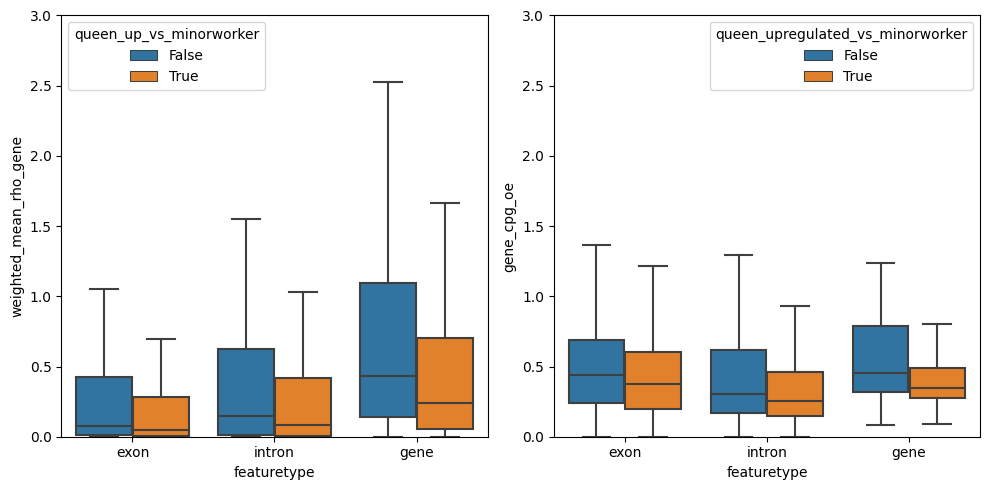

In [129]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue='queen_upregulated_vs_minorworker', dodge=True, fliersize=0, ax=ax) 

sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue='queen_upregulated_vs_minorworker', dodge=True, fliersize=0, ax=ax1) 

ax.set_ylim(0,3)
ax1.set_ylim(0,3)
ax.legend(title='queen_up_vs_minorworker', loc='upper left')

plt.tight_layout()
plt.show()

In [56]:
DEtypes = ['DE', 'DE_royal','king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
       ]

In [57]:
flanks = merged_Mbel.loc[merged_Mbel.featuretype=='gene'][['GeneID', 'mean_rho_flank', 'mean_cpg_flank']]

In [58]:
merged_Mbel_flankall = pd.merge( left=merged_Mbel, right=flanks, left_on='GeneID', right_on='GeneID', how='left')

In [59]:
DE_Mbel.columns

Index(['GeneID', 'Unnamed: 0', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe',
       'scaffold', 'featuretype', 'Start_pos', 'End_pos',
       'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'mean_rho_flank', 'mean_cpg_flank', 'mean_intron_rho', 'mean_exon_rho',
       'intron_cpg_oe', 'exon_cpg_oe', 'GeneID_Mnat', 'DE', 'DE_royal', 'sgo',
       'sgo_mbel', 'sgo_mnat', 'king_upregulated_vs_queen',
       'majorworker_upregulated_vs_king', 'majorworker_upregulated_vs_queen',
       'queen_upregulated_vs_king', 'queen_upregulated_vs_majorworker',
       'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


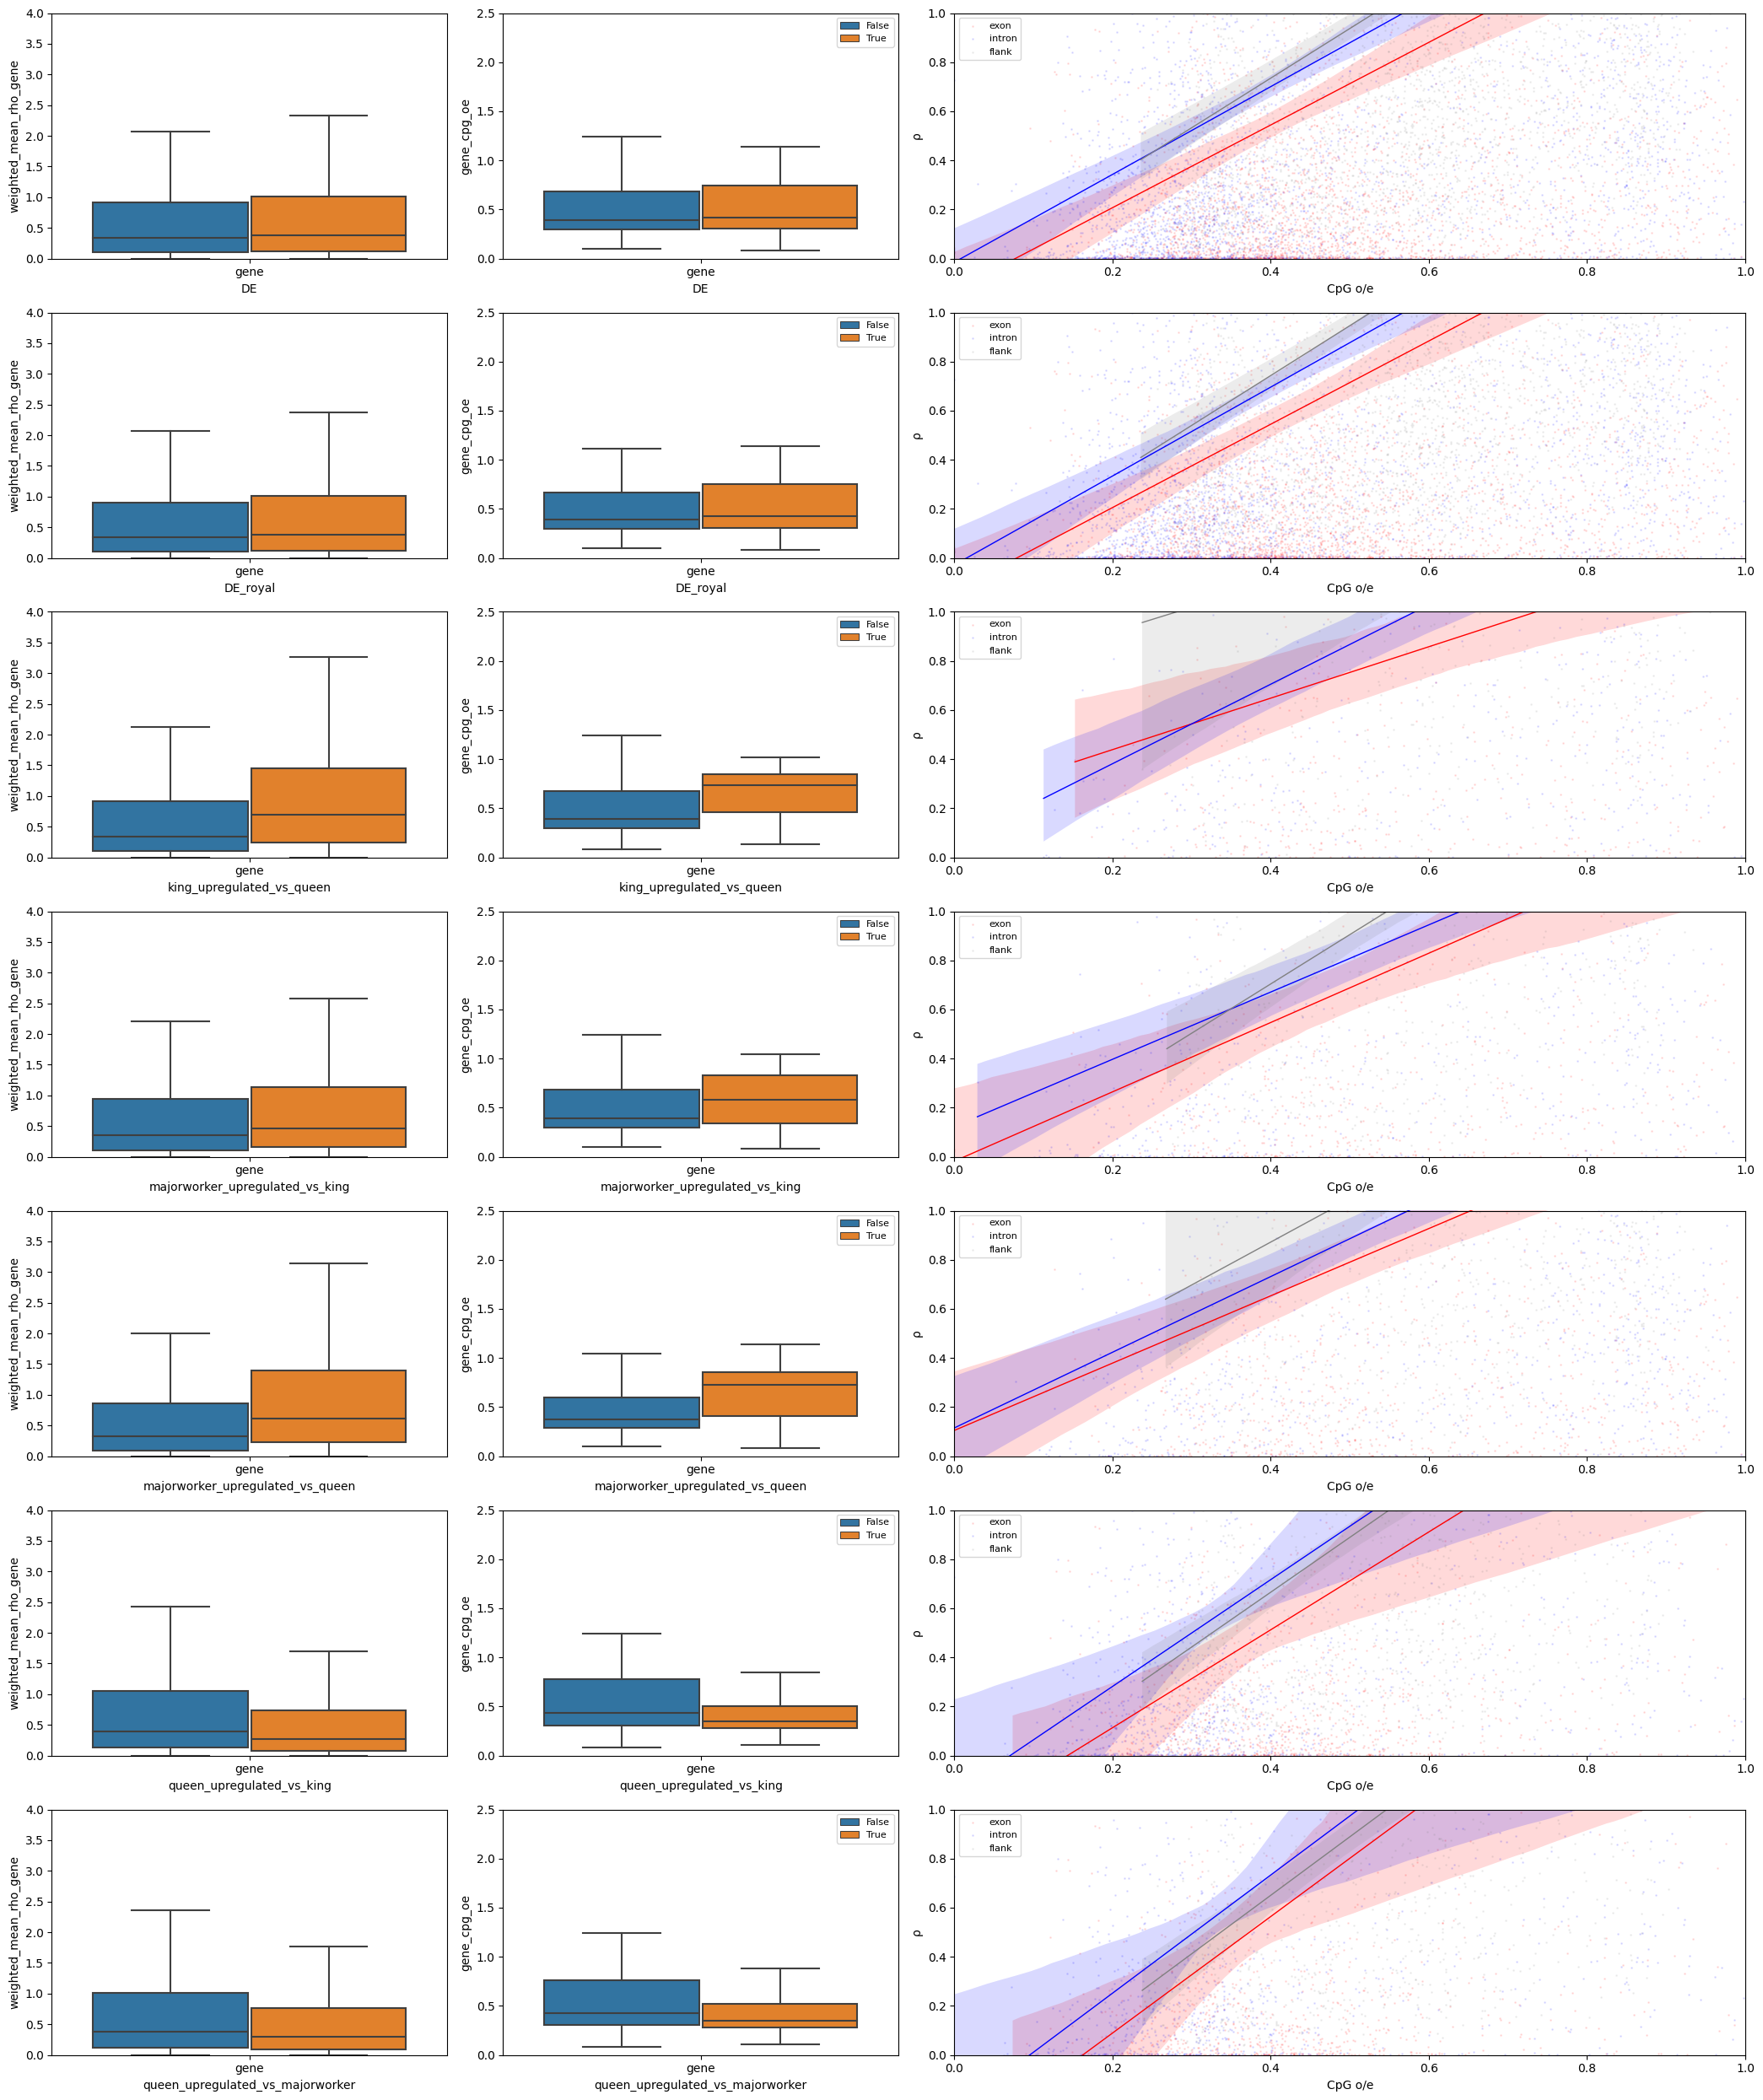

In [75]:
fig, axes = plt.subplots(ncols=3, nrows=7, figsize=(21, 25), sharex=False, sharey='col',gridspec_kw={'width_ratios':(5,5,10)})
for i, k  in enumerate(DEtypes[:7]):
    sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,0])
    sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,1]) 
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='exon_cpg_oe', y='mean_exon_rho', line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'red'}, label='exon',ax=axes[i,2])
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='intron_cpg_oe', y='mean_intron_rho', line_kws={'color':'blue', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'blue'}, label='intron',ax=axes[i,2])
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='mean_cpg_flank', y='mean_rho_flank', line_kws={'color':'grey', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'}, label='flank', ax=axes[i,2])

    axes[i,1].legend(fontsize=8)
    axes[i,0].get_legend().remove()
    axes[i,0].set_ylim(0,4)
    axes[i,1].set_ylim(0,2.5)
    axes[i,0].set_xlabel(k)
    axes[i,1].set_xlabel(k)
    axes[i,2].set_xlabel('CpG o/e')
    axes[i,2].set_ylabel('ρ')

    axes[i,2].set_ylim(0,1)
    axes[i,2].set_xlim(0,1)
    axes[i,2].legend(fontsize=8)
plt.savefig('./figures/20231030_figSJK_A.png',bbox_inches='tight')
plt.savefig('./figures/20231030_figSJK_A.svg',bbox_inches='tight')
plt.savefig('./figures/20231030_figSJK_A.pdf',bbox_inches='tight')
#plt.savefig('./figures/20231030_figSJK_A.eps',bbox_inches='tight',papertype = 'a4')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=7, figsize=(21, 25), sharex=False, sharey='col',gridspec_kw={'width_ratios':(5,5,10)})
for i, k  in enumerate(DEtypes[7:]):
    sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,0])
    sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,1]) 
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='exon_cpg_oe', y='mean_exon_rho', line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'red'}, label='exon',ax=axes[i,2])
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='intron_cpg_oe', y='mean_intron_rho', line_kws={'color':'blue', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'blue'}, label='intron',ax=axes[i,2])
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='mean_cpg_flank', y='mean_rho_flank', line_kws={'color':'grey', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'}, label='flank', ax=axes[i,2])

    axes[i,1].legend(fontsize=8)
    axes[i,0].get_legend().remove()
    axes[i,0].set_ylim(0,4)
    axes[i,1].set_ylim(0,2.5)
    axes[i,0].set_xlabel(k)
    axes[i,1].set_xlabel(k)
    axes[i,2].set_xlabel('CpG o/e')
    axes[i,2].set_ylabel('ρ')

    axes[i,2].set_ylim(0,1)
    axes[i,2].set_xlim(0,1)
    axes[i,2].legend(fontsize=8)
plt.savefig('./figures/20231030_figSJK_B.png',bbox_inches='tight')
plt.savefig('./figures/20231030_figSJK_B.svg',bbox_inches='tight')
plt.savefig('./figures/20231030_figSJK_B.pdf',bbox_inches='tight')
plt.tight_layout()
plt.show()

In [70]:
len(DEtypes)

14

In [68]:
DEtypes[:7]

['DE',
 'DE_royal',
 'king_upregulated_vs_queen',
 'majorworker_upregulated_vs_king',
 'majorworker_upregulated_vs_queen',
 'queen_upregulated_vs_king',
 'queen_upregulated_vs_majorworker']

In [69]:
DEtypes[7:]

['king_upregulated_vs_majorworker',
 'minorworker_upregulated_vs_majorworker',
 'king_upregulated_vs_minorworker',
 'minorworker_upregulated_vs_king',
 'majorworker_upregulated_vs_minorworker',
 'queen_upregulated_vs_minorworker',
 'minorworker_upregulated_vs_queen']

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=14, figsize=(21, 29), sharex=False, sharey='col')
for i, k  in enumerate(DEtypes):
    sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,0])
    sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,1]) 
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='exon_cpg_oe', y='mean_exon_rho', line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'red'}, label='exon',ax=axes[i,2])
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='intron_cpg_oe', y='mean_intron_rho', line_kws={'color':'blue', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'blue'}, label='intron',ax=axes[i,2])
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='mean_cpg_flank', y='mean_rho_flank', line_kws={'color':'grey', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'}, label='flank', ax=axes[i,2])

    axes[i,1].legend(fontsize=8)
    axes[i,0].get_legend().remove()
    axes[i,0].set_ylim(0,4)
    axes[i,1].set_ylim(0,2.5)
    axes[i,0].set_xlabel(k)
    axes[i,1].set_xlabel(k)
    axes[i,2].set_xlabel('CpG o/e')
    axes[i,2].set_ylabel('ρ')

    axes[i,2].set_ylim(0,1)
    axes[i,2].set_xlim(0,1)
    axes[i,2].legend(fontsize=8)
#plt.savefig('./figures/20230922_figSJK.png',bbox_inches='tight')
#plt.savefig('./figures/20230922_figSJK.svg',bbox_inches='tight')
#plt.savefig('./figures/20230922_figSJK.pdf',bbox_inches='tight')

plt.tight_layout()
plt.show()

In [21]:
DE_Mbel

NameError: name 'DE_Mbel' is not defined

In [32]:
DE_Mbel.columns

Index(['Unnamed: 0', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe',
       'scaffold', 'featuretype', 'Start_pos', 'End_pos',
       'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'mean_rho_flank', 'mean_cpg_flank', 'mean_intron_rho', 'mean_exon_rho',
       'intron_cpg_oe', 'exon_cpg_oe', 'GeneID_Mnat', 'DE', 'DE_royal', 'sgo',
       'sgo_mbel', 'sgo_mnat', 'king_upregulated_vs_queen',
       'majorworker_upregulated_vs_king', 'majorworker_upregulated_vs_queen',
       'queen_upregulated_vs_king', 'queen_upregulated_vs_majorworker',
       'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
 

(0.0, 1.5)

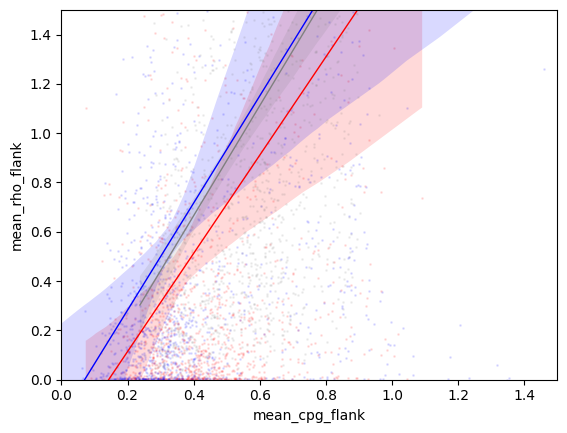

In [262]:
sns.regplot(data=DE_Mbel.loc[DE_Mbel['queen_upregulated_vs_king']==True], x='exon_cpg_oe', y='mean_exon_rho', line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'red'}, label='exon')
sns.regplot(data=DE_Mbel.loc[DE_Mbel['queen_upregulated_vs_king']==True], x='intron_cpg_oe', y='mean_intron_rho', line_kws={'color':'blue', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'blue'}, label='exon')

sns.regplot(data=DE_Mbel.loc[DE_Mbel['queen_upregulated_vs_king']==True], x='mean_cpg_flank', y='mean_rho_flank', line_kws={'color':'grey', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'}, label='exon')

plt.ylim(0,1.5)
plt.xlim(0,1.5)

(array([ 50., 295., 337., 165.,  86.,  47.,  52.,  61.,  64.,  15.]),
 array([0.10831532, 0.19961145, 0.29090758, 0.3822037 , 0.47349983,
        0.56479596, 0.65609209, 0.74738821, 0.83868434, 0.92998047,
        1.0212766 ]),
 <BarContainer object of 10 artists>)

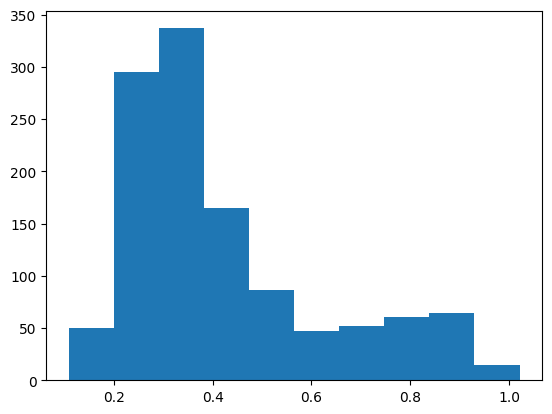

In [249]:
plt.hist(DE_Mbel.loc[DE_Mbel['queen_upregulated_vs_king']==True].gene_cpg_oe)

In [252]:
DE_Mbel.loc[DE_Mbel['queen_upregulated_vs_king']==True].gene_cpg_oe.min()

0.1083153210425937

In [34]:
DE_Mbel.columns

Index(['Unnamed: 0', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe',
       'scaffold', 'featuretype', 'Start_pos', 'End_pos',
       'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'mean_rho_flank', 'mean_cpg_flank', 'mean_intron_rho', 'mean_exon_rho',
       'intron_cpg_oe', 'exon_cpg_oe', 'GeneID_Mnat', 'DE', 'DE_royal', 'sgo',
       'sgo_mbel', 'sgo_mnat', 'king_upregulated_vs_queen',
       'majorworker_upregulated_vs_king', 'majorworker_upregulated_vs_queen',
       'queen_upregulated_vs_king', 'queen_upregulated_vs_majorworker',
       'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
 

In [30]:
DEtypes = ['queen_biased','king_biased','worker_biased', 'male_biased', 'female_biased', 'reproduction_biased', 'DE']

NameError: name 'DE_Csec' is not defined

In [33]:
DE_Mbel.columns

Index(['Unnamed: 0', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe',
       'scaffold', 'featuretype', 'Start_pos', 'End_pos',
       'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'mean_rho_flank', 'mean_cpg_flank', 'mean_intron_rho', 'mean_exon_rho',
       'intron_cpg_oe', 'exon_cpg_oe', 'GeneID_Mnat', 'DE', 'DE_royal', 'sgo',
       'sgo_mbel', 'sgo_mnat', 'king_upregulated_vs_queen',
       'majorworker_upregulated_vs_king', 'majorworker_upregulated_vs_queen',
       'queen_upregulated_vs_king', 'queen_upregulated_vs_majorworker',
       'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
 

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [37]:
mod = smf.ols(formula='weighted_mean_rho_gene ~ + gene_cpg_oe + mean_rho_flank +'+ " + ".join(DEtypes)+' + '+" + gene_cpg_oe:".join(DEtypes), data=DE_Mbel)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     weighted_mean_rho_gene   R-squared:                       0.085
Model:                                OLS   Adj. R-squared:                  0.082
Method:                     Least Squares   F-statistic:                     30.25
Date:                    Tue, 07 Nov 2023   Prob (F-statistic):           3.66e-83
Time:                            16:35:07   Log-Likelihood:                -9869.1
No. Observations:                    4915   AIC:                         1.977e+04
Df Residuals:                        4899   BIC:                         1.987e+04
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [22]:
set(DE_csec.worker_biased)

{'queen-biased', 'unbiased', 'worker-biased'}

In [25]:
DE_csec['wb'] = DE_csec.worker_biased == 'worker-biased'
DE_csec['qb'] = DE_csec.worker_biased == 'queen-biased'

In [26]:
mod = smf.ols(formula='gene_cpg_oe ~ mean_cpg_flank + wb + qb', data=DE_csec)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            gene_cpg_oe   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     726.6
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:58:16   Log-Likelihood:                 1871.4
No. Observations:               11926   AIC:                            -3735.
Df Residuals:                   11922   BIC:                            -3705.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2543      0.007     37.

In [40]:
mod = smf.ols(formula='gene_cpg_oe ~ mean_cpg_flank+'+ " + ".join(DEtypes), data=DE_Mbel)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            gene_cpg_oe   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     250.3
Date:                Tue, 07 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:38:07   Log-Likelihood:                 912.05
No. Observations:                4915   AIC:                            -1806.
Df Residuals:                    4906   BIC:                            -1748.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [62]:
mod = smf.ols(formula='mean_exon_rho ~ + exon_cpg_oe + mean_rho_flank +'+ " + ".join(DEtypes)+' + '+" + gene_cpg_oe:".join(DEtypes), data=DE_Mbel)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          mean_exon_rho   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     9.647
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           9.26e-43
Time:                        15:31:56   Log-Likelihood:                -10512.
No. Observations:                4915   AIC:                         2.109e+04
Df Residuals:                    4884   BIC:                         2.129e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -0.1976      0.120     -1.644      0.100      -0.433       0.038
DE[T.True]                                                     0.0292      0.215      0.136      0.892      -0.392       0.451
DE_royal[T.True]                                              -0.3775      0.336     -1.123      0.261      -1.036       0.281
king_upregulated_vs_queen[T.True]                              0.1423      0.355      0.401      0.688      -0.553       0.838
majorworker_upregulated_vs_king[T.True]                        0.0098      0.286      0.034      0.973      -0.551       0.570
majorworker_upregulated_vs_queen[T.True]                       0.2816      0.306      0.920      0.358      -0.318       0.882
queen_upregulated_vs_king[T.True]                              0.0184      0.356      0.052      0.959      -0.679       0.716
queen_upregulated_vs_majorworker[T.True]                      -0.2062      0.376     -0.548      0.583      -0.943       0.531
king_upregulated_vs_majorworker[T.True]                       -0.0274      0.350     -0.078      0.938      -0.714       0.659
minorworker_upregulated_vs_majorworker[T.True]                 0.3529      0.489      0.721      0.471      -0.606       1.312
king_upregulated_vs_minorworker[T.True]                        0.5227      0.305      1.713      0.087      -0.076       1.121
minorworker_upregulated_vs_king[T.True]                        0.3333      0.389      0.856      0.392      -0.430       1.097
majorworker_upregulated_vs_minorworker[T.True]                 0.1962      0.240      0.817      0.414      -0.275       0.667
queen_upregulated_vs_minorworker[T.True]                       0.1474      0.283      0.520      0.603      -0.408       0.703
minorworker_upregulated_vs_queen[T.True]                      -0.1826      0.338     -0.540      0.589      -0.846       0.480
exon_cpg_oe                                                    0.5006      0.218      2.292      0.022       0.072       0.929
mean_rho_flank                                                 0.2049      0.021      9.764      0.000       0.164       0.246
gene_cpg_oe:DE_royal[False]                                    0.9273      0.256      3.621      0.000       0.425       1.429
gene_cpg_oe:DE_royal[True]                                     1.8182      0.503      3.612      0.000       0.831       2.805
gene_cpg_oe:king_upregulated_vs_queen[T.True]                 -0.4415      0.518     -0.852      0.394      -1.457       0.574
gene_cpg_oe:majorworker_upregulated_vs_king[T.True]           -0.1517      0.470     -0.323      0.747      -1.073       0.769
gene_cpg_oe:majorworker_upregulated

In [301]:
DE_csec.columns

Index(['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID', 'gene_cpg_e', 'gene_cpg_o',
       'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o', 'flank_u_cpg_oe',
       'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe', 'GeneID',
       'featuretype', 'source', 'start', 'stop', 'n', 'strand', 'n2',
       'mean_rho_flank', 'mean_cpg_flank', 'mean_intron_rho', 'mean_exon_rho',
       'intron_cpg_oe', 'exon_cpg_oe', 'geneNumber', 'Csec_geneName',
       'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'worker_biased', 'queen_biased'],
      dtype='object')

In [44]:
mod = smf.ols(formula='weighted_mean_rho_gene ~ + gene_cpg_oe + mean_rho_flank + worker_biased + gene_cpg_oe:worker_biased', data=DE_csec)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     weighted_mean_rho_gene   R-squared:                       0.172
Model:                                OLS   Adj. R-squared:                  0.171
Method:                     Least Squares   F-statistic:                     412.3
Date:                    Tue, 07 Nov 2023   Prob (F-statistic):               0.00
Time:                            16:46:37   Log-Likelihood:                -35329.
No. Observations:                   11926   AIC:                         7.067e+04
Df Residuals:                       11919   BIC:                         7.072e+04
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [45]:
mod = smf.ols(formula='mean_intron_rho ~ + intron_cpg_oe + mean_rho_flank + worker_biased + gene_cpg_oe:worker_biased', data=DE_csec)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_intron_rho   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     317.4
Date:                Tue, 07 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:47:06   Log-Likelihood:                -36092.
No. Observations:               11923   AIC:                         7.220e+04
Df Residuals:                   11915   BIC:                         7.226e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.1094      0.687      0.159      0.873      -1.238       1.456
worker_biased[T.unbiased]                    0.5208      0.698      0.746      0.456      -0.847       1.889
worker_biased[T.worker-biased]               0.4859      0.845      0.575      0.565      -1.170       2.142
intron_cpg_oe                               -0.0363      0.415     -0.087      0.930      -0.850       0.778
mean_rho_flank                               0.6134      0.013     45.742      0.000       0.587       0.640
gene_cpg_oe:worker_biased[queen-biased]      2.1473      1.099      1.954      0.051      -0.007       4.302
gene_cpg_oe:worker_biased[unbiased]          1.4717      0.483      3.049      0.002       0.526       2.418
gene_cpg_oe:worker_biased[worker-biased]     1.0210      0.909      1.123      0.261      -0.761       2.803
==============================================================================
Omnibus:                    12947.650   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2099608.393
Skew:                           5.263   Prob(JB):                         0.00
Kurtosis:                      67.153   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
mod = smf.ols(formula='mean_exon_rho ~ + exon_cpg_oe + mean_rho_flank + worker_biased + gene_cpg_oe:worker_biased', data=DE_csec)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          mean_exon_rho   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     256.5
Date:                Tue, 07 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:47:27   Log-Likelihood:                -37468.
No. Observations:               11926   AIC:                         7.495e+04
Df Residuals:                   11918   BIC:                         7.501e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

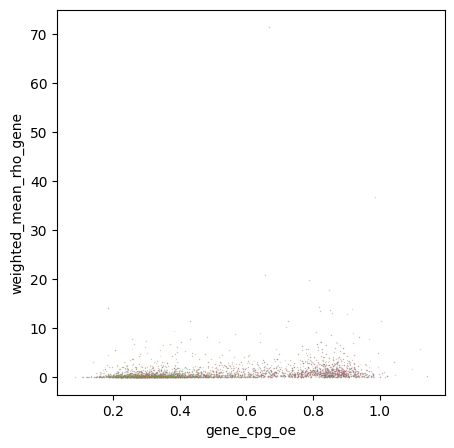

In [239]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharex=False, sharey='col')

for i, k  in enumerate(DEtypes):
    sns.scatterplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=ax, alpha=0.1, s=1)

In [ ]:
?sns.regplot

In [4]:
cpg_chunks_df = pd.read_csv('./Mbel/20230811_Mbel_CpG_per_gene_and_5okbflank_and_10kb_buffer_18batchmiss.tsv', sep='\t')
cpg_chunks_df_melt = cpg_chunks_df.melt(id_vars=['ID'], value_vars=['gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o','flank_u_cpg_oe','flank_d_cpg_e','flank_d_cpg_o','flank_d_cpg_oe'] )
cpg_chunks_df_melt_oe = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable.isin(['gene_cpg_oe', 'flank_u_cpg_oe', 'flank_d_cpg_oe'])]

In [19]:
cpg_chunks_exin_df = pd.read_csv('./Mbel/20230717_Mbel_CpG_exons_and_introns.tsv', sep='\t')
cpg_chunks_exin_df['gene_id'] = [i.rsplit('.',1)[0] for i in cpg_chunks_exin_df.ID]
cpg_chunks_exin_df['reg_id'] = [i.rsplit('.',1)[1] for i in cpg_chunks_exin_df.ID]
cpg_chunks_exin_df['reg_type'] = [''.join(i for i in st if i.isalpha()) for st in cpg_chunks_exin_df.reg_id]


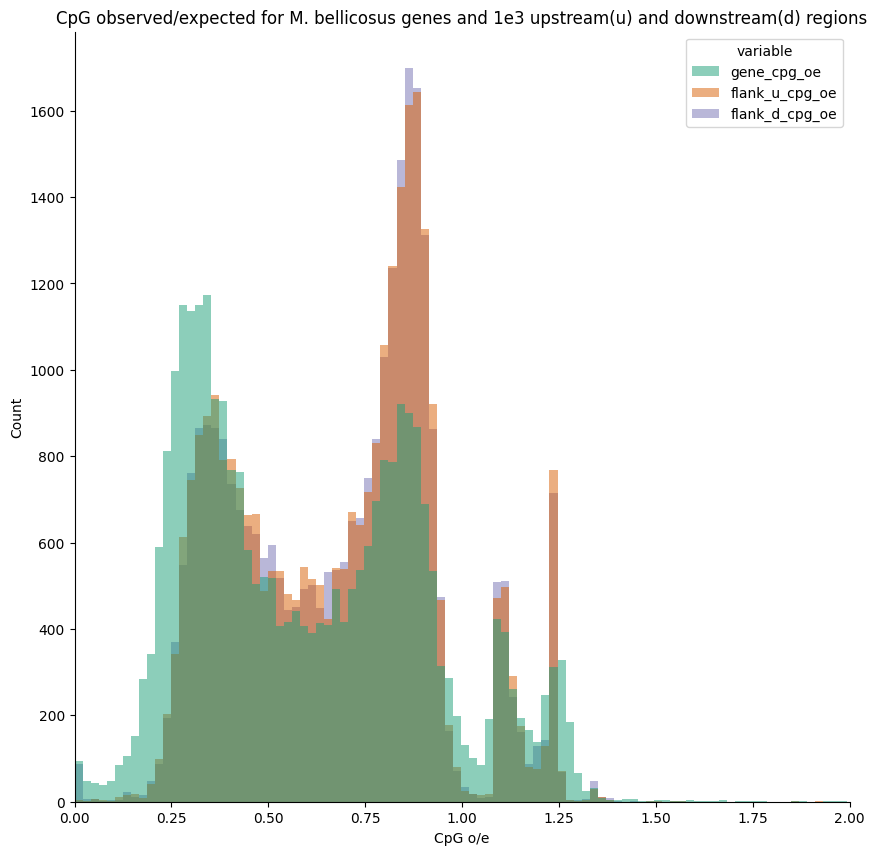

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
sns.histplot(data=cpg_chunks_df_melt_oe, x="value", hue="variable",linewidth=0, palette = ['#1b9e77','#d95f02','#7570b3'])

ax.set_xlim(0,2)
ax.set_title('CpG observed/expected for M. bellicosus genes and 1e3 upstream(u) and downstream(d) regions')
ax.set_xlabel('CpG o/e')

sns.despine()
plt.show()


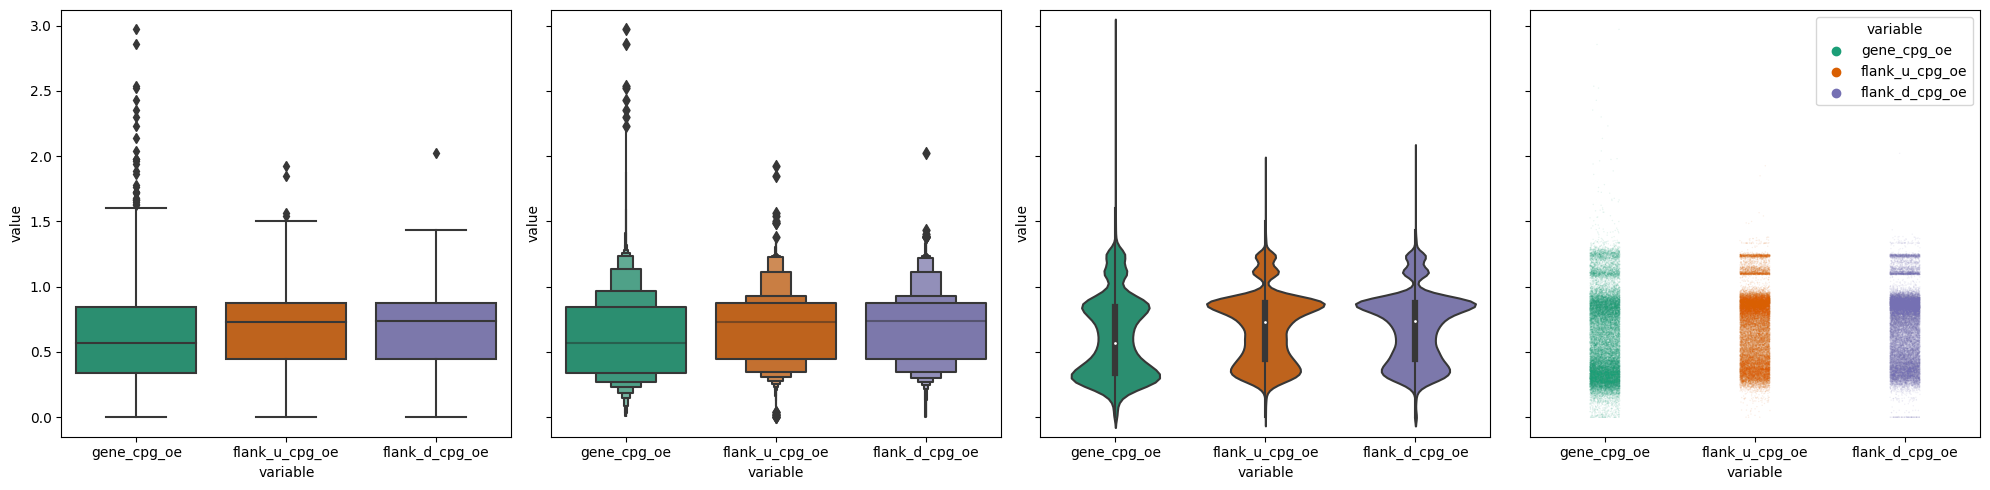

In [8]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(ncols=4, nrows=1, figsize=(20,5), sharey=True, sharex=True)
sns.boxplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax)
sns.boxenplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax1)
sns.violinplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax2)
sns.stripplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', hue='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax3, alpha=0.1, s=1)

plt.tight_layout()
plt.show()

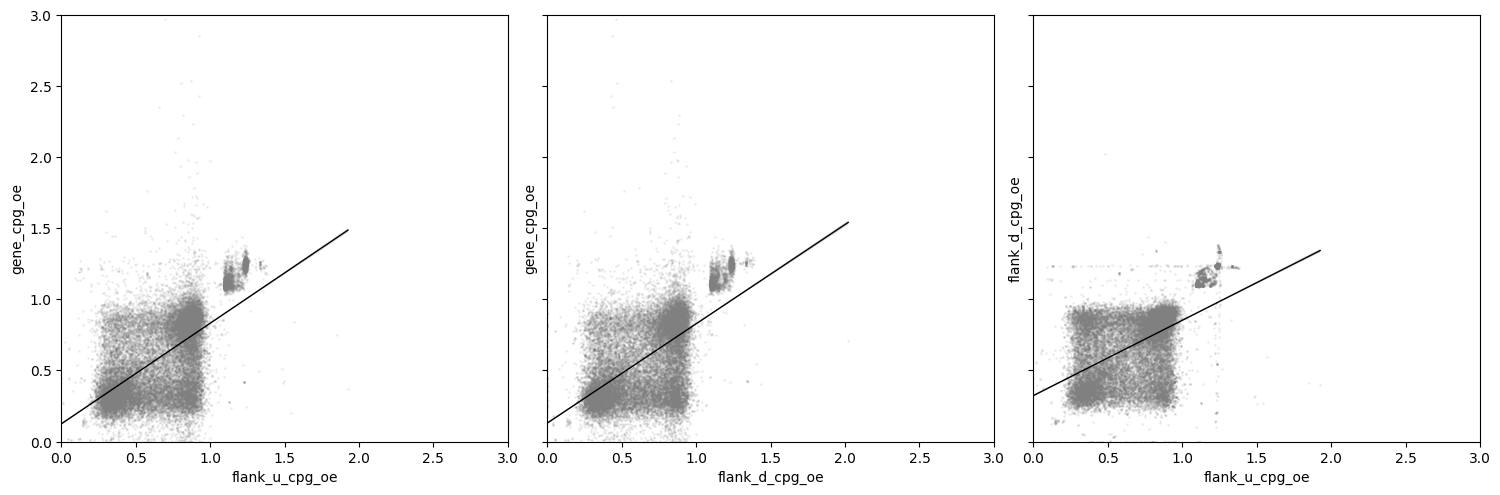

In [9]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True, sharex=True)

sns.regplot(data=cpg_chunks_df, x="flank_u_cpg_oe", y="gene_cpg_oe", ax=ax, line_kws={'color':'black', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'} )
sns.regplot(data=cpg_chunks_df, x="flank_d_cpg_oe", y="gene_cpg_oe", ax=ax1, line_kws={'color':'black', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'} )
sns.regplot(data=cpg_chunks_df, x="flank_u_cpg_oe", y="flank_d_cpg_oe", ax=ax2, line_kws={'color':'black', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'} )

plt.tight_layout()
ax.set_ylim(0,3)
ax.set_xlim(0,3)

plt.show()

,Unnamed: 0,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,gene_id,reg_id
0,0,g22731.t1.intron6,21.374046,0,0.000000,g22731.t1,intron6
1,1,g22731.t1.CDS7,16.271186,6,0.368750,g22731.t1,CDS7
2,2,g22731.t1.exon7,16.271186,6,0.368750,g22731.t1,exon7
3,3,g22731.t1.intron7,37.698344,5,0.132632,g22731.t1,intron7
4,4,g22731.t1.CDS8,17.885350,6,0.335470,g22731.t1,CDS8
...,...,...,...,...,...,...,...
827904,4135,g10458.t1.CDS3,8.888889,6,0.675000,g10458.t1,CDS3
827905,4136,g10458.t1.exon3,8.888889,6,0.675000,g10458.t1,exon3
827906,4137,g10458.t1.intron3,58.456164,18,0.307923,g10458.t1,intron3
827907,4138,g10458.t1.CDS4,3.781818,2,0.528846,g10458.t1,CDS4


In [20]:
cpg_chunks_exin_df_onlyexin = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.reg_type.isin(['exon', 'intron'])]
cpg_chunks_exin_df_onlyexin.groupby('reg_type')['gene_cpg_oe'].mean()

reg_type
exon      0.564167
intron    0.482606
Name: gene_cpg_oe, dtype: float64

In [21]:
cpg_chunks_exin_df_onlyexin.groupby('reg_type')['gene_cpg_oe'].sem()

reg_type
exon      0.000850
intron    0.000768
Name: gene_cpg_oe, dtype: float64

In [22]:
cpg_chunks_exin_df_onlyexin.groupby('reg_type')['gene_cpg_oe'].std()

reg_type
exon      0.438275
intron    0.372242
Name: gene_cpg_oe, dtype: float64

In [23]:
cpg_chunks_df_melt.groupby('variable')['value'].mean()

variable
flank_d_cpg_e     2359.899680
flank_d_cpg_o     1832.578890
flank_d_cpg_oe       0.687312
flank_u_cpg_e     2517.649043
flank_u_cpg_o     1940.262923
flank_u_cpg_oe       0.686788
gene_cpg_e         955.367334
gene_cpg_o         558.520832
gene_cpg_oe          0.610369
Name: value, dtype: float64

In [24]:
cpg_chunks_df_melt.groupby('variable')['value'].sem()

variable
flank_d_cpg_e      7.265377
flank_d_cpg_o     10.336996
flank_d_cpg_oe     0.001529
flank_u_cpg_e     32.743299
flank_u_cpg_o     25.460435
flank_u_cpg_oe     0.001519
gene_cpg_e         7.809463
gene_cpg_o         5.355798
gene_cpg_oe        0.001800
Name: value, dtype: float64

In [25]:
cpg_chunks_df_melt.groupby('variable')['value'].std()

variable
flank_d_cpg_e     1248.334732
flank_d_cpg_o     1776.099347
flank_d_cpg_oe       0.262674
flank_u_cpg_e     5625.942935
flank_u_cpg_o     4374.603604
flank_u_cpg_oe       0.260958
gene_cpg_e        1341.819299
gene_cpg_o         920.231526
gene_cpg_oe          0.309197
Name: value, dtype: float64

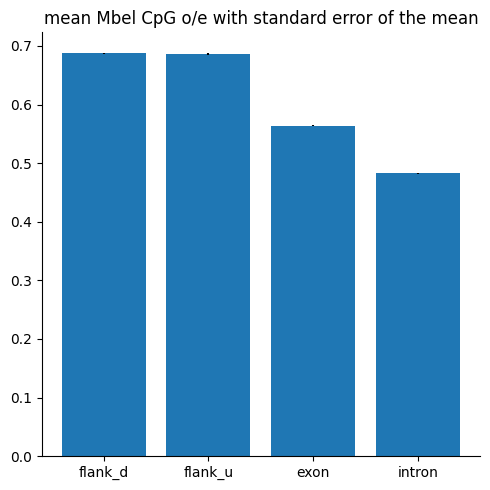

In [29]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
ax.bar(height = [0.687312,0.686788, 0.564167,0.482606 ], x=['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.001529,0.001519,0.000850,0.000768])
#ax1.bar(height = [0.670841,0.675701, 0.564167,0.482606 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.362396,0.362441,0.438275,0.372242])

ax.set_title("mean Mbel CpG o/e with standard error of the mean")
#ax1.set_title("mean CpG o/e with standard deviation")
sns.despine()
plt.tight_layout()
plt.show()

In [30]:
fd = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable =='flank_d_cpg_oe' ]['value']
fu = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable =='flank_u_cpg_oe' ]['value']
ex = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.reg_type =='exon']['gene_cpg_oe']
intr = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.reg_type =='intron']['gene_cpg_oe']

In [31]:
thsd = scipy.stats.tukey_hsd(fd, fu, ex, intr)

In [33]:
print(thsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.001     0.999    -0.008     0.009
 (0 - 2)      0.123     0.000     0.117     0.129
 (0 - 3)      0.205     0.000     0.198     0.211
 (1 - 0)     -0.001     0.999    -0.009     0.008
 (1 - 2)      0.123     0.000     0.116     0.129
 (1 - 3)      0.204     0.000     0.198     0.210
 (2 - 0)     -0.123     0.000    -0.129    -0.117
 (2 - 1)     -0.123     0.000    -0.129    -0.116
 (2 - 3)      0.082     0.000     0.079     0.084
 (3 - 0)     -0.205     0.000    -0.211    -0.198
 (3 - 1)     -0.204     0.000    -0.210    -0.198
 (3 - 2)     -0.082     0.000    -0.084    -0.079



# Csec - DE

In [176]:
DE_data = pd.read_csv('./Csec/old_data/DE_data/Queen_up_v_worker.tsv', comment='#', sep='\t')
DE_data.log2FoldChange = [ float(i.replace(',', '.')) for i in DE_data.log2FoldChange]
DE_data['worker_biased'] = DE_data.log2FoldChange>0
DE_data['queen_biased'] = DE_data.log2FoldChange<0
tdf = pd.read_csv('./Csec/old_data/DE_data/DE_ID_list.txt', sep='\t')
tdf = pd.read_csv('./Csec/old_data/DE_data/DE_ID_list.txt', sep='\t')
tdict = {}
for i, k in tdf.iterrows():
    gid_old = str(k.Aliases).split(',')[0]
    if not gid_old  == 'nan':
        if gid_old.startswith('B7P43_'):
            gid_mod = 'Csec_'+gid_old.split('_')[1]
            tdict[gid_mod] = 'GeneID:'+str(k.GeneID)
        else:
            print(k.Aliases)
gids_DE =[] 
for i, k in DE_data.iterrows():
    try:
        gids_DE.append(tdict[k.Csec_geneName])
    except KeyError:
        gids_DE.append(np.nan)

DE_data['GeneID'] = gids_DE

DE_data = DE_data.dropna(subset='GeneID')

DE_csec = mm4_Csec_gene.merge(right=DE_data, left_on='GeneID', right_on='GeneID')

In [177]:
tdf = pd.read_csv('./Csec/old_data/DE_data/DE_ID_list.txt', sep='\t')
tdict = {}
for i, k in tdf.iterrows():
    gid_old = str(k.Aliases).split(',')[0]
    if not gid_old  == 'nan':
        if gid_old.startswith('B7P43_'):
            gid_mod = 'Csec_'+gid_old.split('_')[1]
            tdict[gid_mod] = 'GeneID:'+str(k.GeneID)
        else:
            print(k.Aliases)
gids_DE =[] 
for i, k in DE_data.iterrows():
    try:
        gids_DE.append(tdict[k.Csec_geneName])
    except KeyError:
        gids_DE.append(np.nan)

DE_data['GeneID'] = gids_DE

DE_data = DE_data.dropna(subset='GeneID')

DE_csec = mm4_Csec_gene.merge(right=DE_data, left_on='GeneID', right_on='GeneID')

LTA4H_3
LTA4H_3
CYP6K1_11
CYP6K1_11, CYP6K1_6
RBL1_1
RBL1_1
DHRS11_9
DHRS11_9
DHRS11_9
DHRS11_9
Nif3l1_3
Nif3l1_3
CYP6J1_1
CYP6J1_1
UGT2B19_2
UGT2B19_2
Aldh1a2_2
Aldh1a2_2
UGT2B30_3
UGT2B30_3
UGT2B30_3, Ugt8
AKR1E2_1
AKR1E2_1
ESTF_15
Cg25C
Cg25C
SDR-1_5
SDR-1_5
SDR-1_5
Esd
Esd
Pak4_2
Pak4_2
PPP5C_1
PPP5C_1


In [50]:
#[i.split('_')[1] for i in DE_data.Csec_geneName]

In [27]:
#[str(i).split(',')[0] for i in tdf.Aliases]

In [178]:
DE_data = DE_data.dropna(subset='GeneID')

In [179]:
DE_csec = mm4_Csec_gene.merge(right=DE_data, left_on='GeneID', right_on='GeneID')

In [180]:
DE_csec

,scaffold,weighted_mean_rho_gene,weighted_mean_rho_uflank,weighted_mean_rho_dflank,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,flank_u_cpg_e,flank_u_cpg_o,...,geneNumber,Csec_geneName,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,worker_biased,queen_biased
0,NEVH01010477.1,16.360745,4.572091,5.205236,ID=gene-LOC111865148;Dbxref=GeneID:111865148;N...,532.164834,428,0.804262,1769.450800,1525.0,...,gene6835,Csec_G02456,"5,785473452",-3.304735,"0,993084149","-3,327749665","0,000875505","0,011083606",False,True
1,NEVH01010477.1,4.684808,1.236006,1.282618,ID=gene-LOC111865141;Dbxref=GeneID:111865141;N...,197.515947,178,0.901193,2179.497600,1764.0,...,gene6841,Csec_G02462,"1679,416881",0.439808,"0,124043961","3,545581339","0,000391748","0,006079983",True,False
2,NEVH01010478.1,3.069498,2.550080,2.226948,ID=gene-LOC111865161;Dbxref=GeneID:111865161;N...,3466.340027,2967,0.855946,1927.763400,1446.0,...,gene6855,Csec_G03874,"499,2728913",0.912219,"0,327405846","2,786201278","0,005332975","0,043169075",True,False
3,NEVH01010478.1,4.781772,5.037014,5.828206,ID=gene-LOC111865154;Dbxref=GeneID:111865154;N...,829.223065,391,0.471526,1719.054360,668.0,...,gene6863,Csec_G03882,"1141,331527",0.293663,"0,10383432","2,828192466","0,004681165","0,038892916",True,False
4,NEVH01010479.1,0.283525,0.697196,3.106939,ID=gene-LOC111865194;Dbxref=GeneID:111865194;N...,1107.645654,452,0.408073,1484.399440,552.0,...,gene6873,Csec_G04879,"503,6607512",-0.357667,"0,119368654","-2,996326248","0,002732539","0,02607564",False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358,NEVH01020933.1,2.742516,4.165409,6.295246,ID=gene-LOC111871367;Dbxref=GeneID:111871367;N...,602.639401,243,0.403226,1807.026760,825.0,...,gene13784,Csec_G03030,"464,1480019",0.463554,"0,161386264","2,872324104","0,004074648","0,035557073",True,False
1359,NEVH01004957.1,1.845764,3.119034,0.305826,ID=gene-LOC111861560;Dbxref=GeneID:111861560;N...,5482.412290,4338,0.791258,783.537860,388.0,...,gene2891,Csec_G16550,"2029,269249",0.746678,"0,116007625","6,436459555","1,22E-10","1,71E-08",True,False
1360,NEVH01004959.1,0.087661,1.459708,1.032758,ID=gene-LOC111861583;Dbxref=GeneID:111861583;N...,313.738276,85,0.270926,1710.232020,543.0,...,gene2915,Csec_G16697,"4446,346722",0.254912,"0,085777392","2,971788088","0,00296071","0,027907504",True,False
1361,NEVH01004961.1,8.728204,6.395327,14.622728,ID=gene-LOC111861591;Dbxref=GeneID:111861591;N...,848.542192,534,0.629315,1905.228260,1024.0,...,gene2934,Csec_G16960,"400,5693237",-1.866619,"0,373507816","-4,997535893","5,81E-07","2,62E-05",False,True


In [31]:
DE_csec

,scaffold,weighted_mean_rho_gene,weighted_mean_rho_uflank,weighted_mean_rho_dflank,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,flank_u_cpg_e,flank_u_cpg_o,...,geneNumber,Csec_geneName,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,worker_biased,queen_biased
0,NEVH01021676.1,5.643448,NaN,1.558269,ID=gene-LOC111871994;Dbxref=GeneID:111871994;N...,168.344536,49,0.291070,57.650436,25.0,...,gene14516,Csec_G18241,"220,6407183",1.169612,"0,259877729","4,500626133","6,78E-06","0,000213655",True,False
1,NEVH01021676.1,27.39946,NaN,NaN,ID=exon-XM_033754472.1-1;Parent=rna-XM_0337544...,5.655405,6,1.060932,NaN,NaN,...,gene14516,Csec_G18241,"220,6407183",1.169612,"0,259877729","4,500626133","6,78E-06","0,000213655",True,False
2,NEVH01021676.1,9.591749098039214,NaN,NaN,Parent=rna-XM_033754472.1,66.830065,22,0.329193,NaN,NaN,...,gene14516,Csec_G18241,"220,6407183",1.169612,"0,259877729","4,500626133","6,78E-06","0,000213655",True,False
3,NEVH01021676.1,3.102534952229299,NaN,NaN,Parent=rna-XM_033754472.1,66.830065,22,0.329193,NaN,NaN,...,gene14516,Csec_G18241,"220,6407183",1.169612,"0,259877729","4,500626133","6,78E-06","0,000213655",True,False
4,NEVH01021676.1,0.11710460847240052,NaN,NaN,Parent=rna-XM_033754472.1,66.830065,22,0.329193,NaN,NaN,...,gene14516,Csec_G18241,"220,6407183",1.169612,"0,259877729","4,500626133","6,78E-06","0,000213655",True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869687,NEVH01002989.1,1.127852611530104,NaN,NaN,Parent=rna-XM_023871212.1,2752.479471,2320,0.842876,NaN,NaN,...,gene1857,Csec_G07667,"2036,791383",0.792832,"0,234786595","3,376818436","0,000733294","0,009676464",True,False
869688,NEVH01002989.1,5.381591545696996,NaN,NaN,Parent=rna-XM_023871212.1,2752.479471,2320,0.842876,NaN,NaN,...,gene1857,Csec_G07667,"2036,791383",0.792832,"0,234786595","3,376818436","0,000733294","0,009676464",True,False
869689,NEVH01002989.1,4.45768,NaN,NaN,ID=exon-XM_023871212.1-3;Parent=rna-XM_0238712...,7.660714,5,0.652681,NaN,NaN,...,gene1857,Csec_G07667,"2036,791383",0.792832,"0,234786595","3,376818436","0,000733294","0,009676464",True,False
869690,NEVH01002989.1,0.00393,NaN,NaN,ID=exon-XM_023871212.1-2;Parent=rna-XM_0238712...,12.662577,7,0.552810,NaN,NaN,...,gene1857,Csec_G07667,"2036,791383",0.792832,"0,234786595","3,376818436","0,000733294","0,009676464",True,False


In [32]:
DE_csec_melt = DE_csec.melt(id_vars=['GeneID', 'featuretype']+['worker_biased', 'queen_biased'], value_vars=['gene_cpg_oe','weighted_mean_rho_gene', 'mean_cpg_flank','mean_rho_flank' ])

In [42]:
Csec_melt = merged_Csec.melt(value_vars=['gene_cpg_oe','weighted_mean_rho_gene' ,'mean_rho_flank','mean_cpg_flank'], id_vars=['GeneID', 'scaffold','featuretype']).replace('no_overlap_bin', np.nan)
Csec_melt.value = Csec_melt.value.astype(float)

ft2 = []
for i,k in Csec_melt.iterrows():
    if k.variable.startswith('mean'):
        ft2.append('flank')
    else:
        ft2.append(k.featuretype)
Csec_melt['ft2'] = ft2

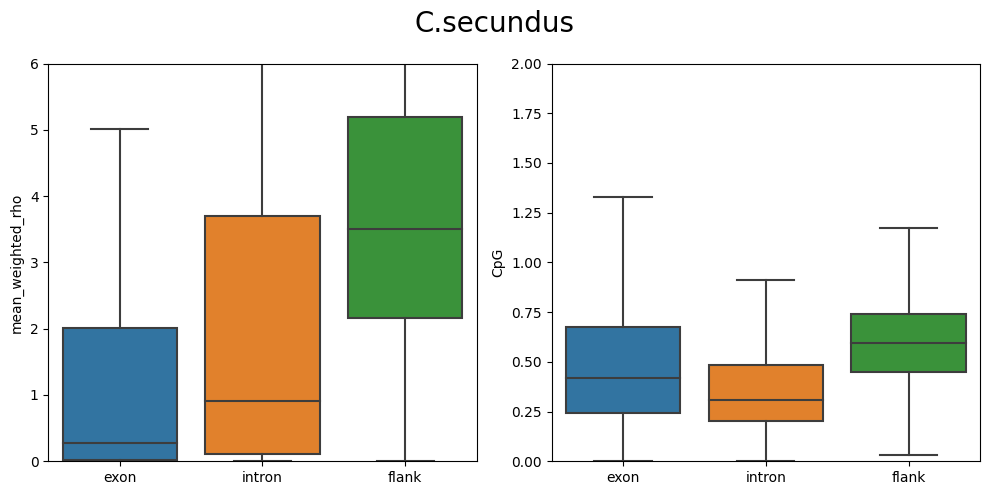

In [43]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.boxplot(data=Csec_melt.loc[Csec_melt.variable.isin(['weighted_mean_rho_gene','mean_rho_flank'])].loc[Csec_melt.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', fliersize=0, ax=ax)

sns.boxplot(data=Csec_melt.loc[Csec_melt.variable.isin(['gene_cpg_oe','mean_cpg_flank'])].loc[Csec_melt.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', fliersize=0, ax=ax1)
ax.set_ylabel('mean_weighted_rho')
ax1.set_ylabel('CpG')

ax.set_xlabel('')
ax1.set_xlabel('')

ax.set_ylim(0,6)
ax1.set_ylim(0,2)

fig.suptitle('C.secundus', size=20)
plt.tight_layout()
plt.show()

In [99]:
DE_csec_melt.to_csv('./Csec_DE_melt.tsv', sep='\t')

In [100]:
merged_Csec.to_csv('./merged_Csec.tsv', sep='\t')

In [33]:
ft2 = []
for i,k in DE_csec_melt.iterrows():
    if k.variable.startswith('mean'):
        ft2.append('flank')
    else:
        ft2.append(k.featuretype)
DE_csec_melt['ft2'] = ft2

In [38]:
DE_csec_melt.value = DE_csec_melt.value.replace('no_overlap_bin', np.nan).astype(float)

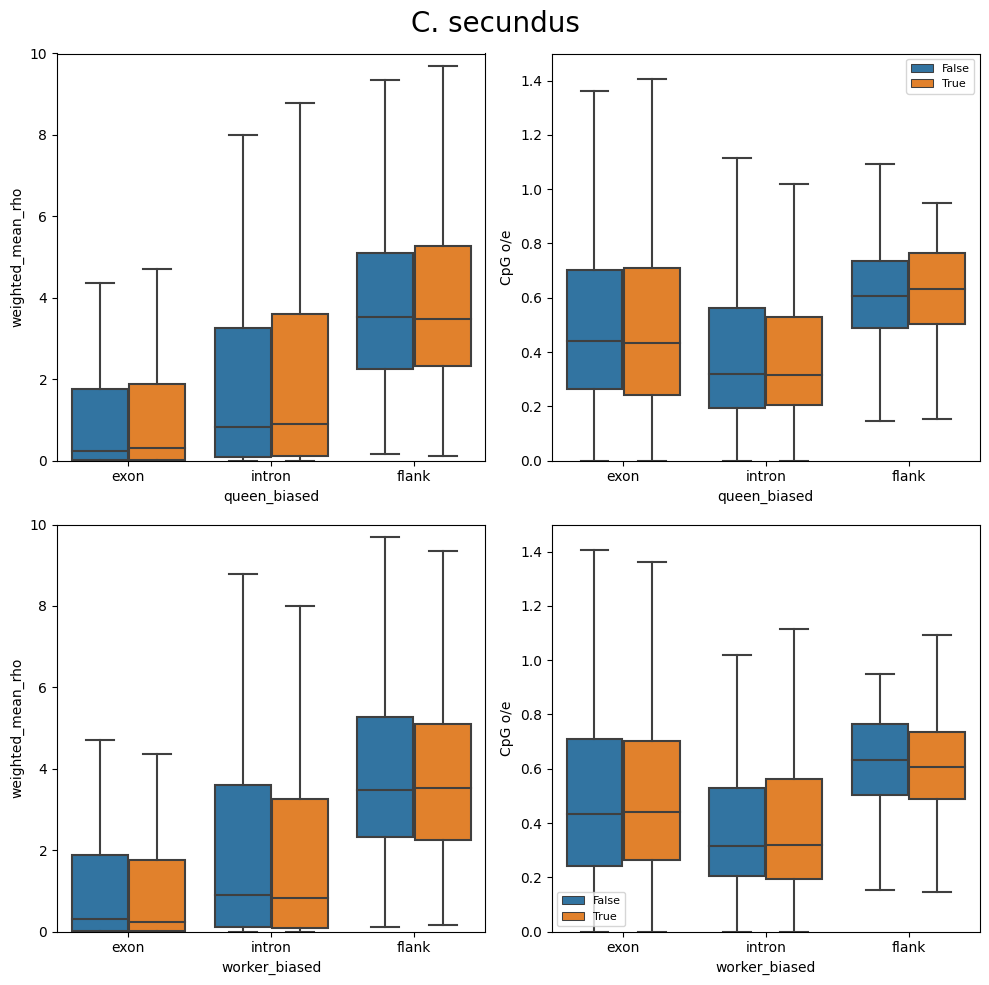

In [41]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharex=False, sharey='col')
for i, k  in enumerate(['queen_biased', 'worker_biased']):
    #ss_de = DE_Mbel_melt.loc[DE_Mbel_melt[k]==True]
    ss_de = DE_csec_melt

    sns.boxplot(data=ss_de.loc[ss_de.variable.isin(['weighted_mean_rho_gene','mean_rho_flank'])].loc[ss_de.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', hue=k, fliersize=0, ax= axes[i,0])
    sns.boxplot(data=ss_de.loc[ss_de.variable.isin(['gene_cpg_oe','mean_cpg_flank'])].loc[ss_de.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', hue=k, fliersize=0, ax=axes[i,1])
    #sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,0])
    #sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,1]) 
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='exon'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'red'}, label='exon')
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='intron'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'blue', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'blue'}, label='intron')
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='gene'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'purple', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'purple'}, label='gene')
    
    axes[i,1].legend(fontsize=8)
    axes[i,0].get_legend().remove()
    axes[i,0].set_ylim(0,10)
    axes[i,1].set_ylim(0,1.5)
    axes[i,0].set_xlabel(k)

    axes[i,0].set_ylabel('weighted_mean_rho')
    axes[i,1].set_ylabel('CpG o/e')
    axes[i,1].set_xlabel(k)
    #axes[i,2].set_xlabel(k)
    #axes[i,2].set_ylim(0,10)
    #axes[i,2].set_xlim(0,10)
    #axes[i,2].legend(fontsize=8)
plt.suptitle('C. secundus', fontsize=20)
#plt.savefig('./figures/20230810_Mbel_DE_panel.png',bbox_inches='tight')
#plt.savefig('./figures/20230810_Mbel_DE_panel.svg',bbox_inches='tight')
plt.tight_layout()
plt.show()

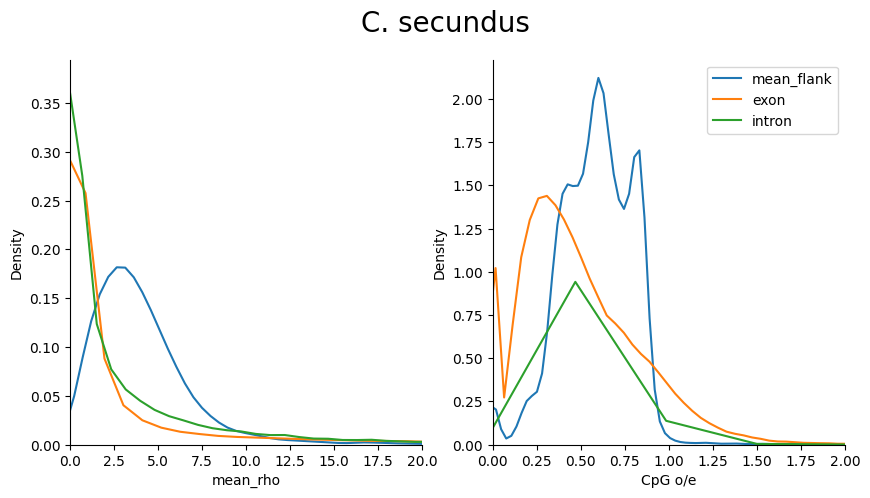

In [51]:
fig, (ax,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='gene'].mean_rho_flank.astype(float), label='mean_flank', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='exon'].weighted_mean_rho_gene.replace('no_overlap_bin', np.nan).astype(float), label='exon', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='intron'].weighted_mean_rho_gene.replace('no_overlap_bin', np.nan).astype(float), label='intron', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])


sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='gene'].mean_cpg_flank.astype(float), label='mean_flank', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='exon'].gene_cpg_oe.replace('no_overlap_bin', np.nan).astype(float), label='exon', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='intron'].gene_cpg_oe.replace('no_overlap_bin', np.nan).astype(float), label='intron', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])


plt.legend()
ax1.set_xlim(0,2)

ax.set_xlim(0,20)
plt.suptitle('C. secundus', fontsize=20)
ax1.set_xlabel('CpG o/e')
ax.set_xlabel('mean_rho')
sns.despine()
plt.show()


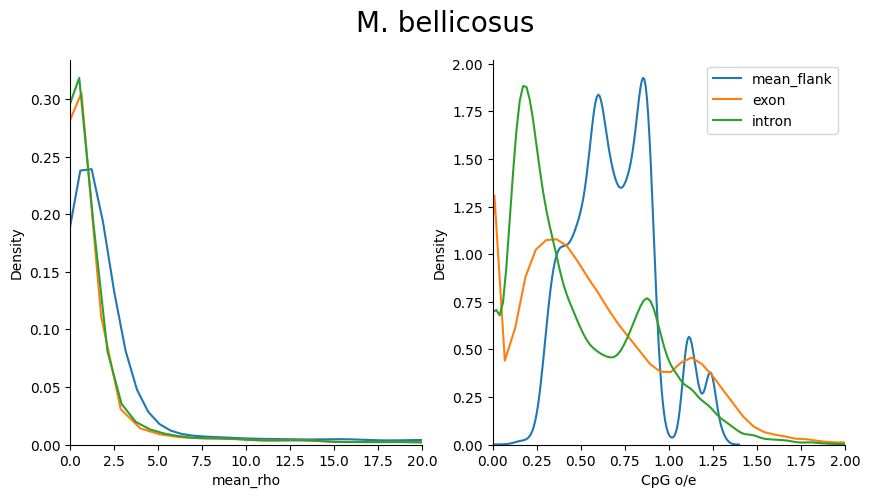

In [52]:
fig, (ax,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='gene'].mean_rho_flank.astype(float), label='mean_flank', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='exon'].weighted_mean_rho_gene.replace('no_overlap_bin', np.nan).astype(float), label='exon', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='intron'].weighted_mean_rho_gene.replace('no_overlap_bin', np.nan).astype(float), label='intron', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])


sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='gene'].mean_cpg_flank.astype(float), label='mean_flank', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='exon'].gene_cpg_oe.replace('no_overlap_bin', np.nan).astype(float), label='exon', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='intron'].gene_cpg_oe.replace('no_overlap_bin', np.nan).astype(float), label='intron', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])


plt.legend()
ax1.set_xlim(0,2)

ax.set_xlim(0,20)
plt.suptitle('M. bellicosus', fontsize=20)
ax1.set_xlabel('CpG o/e')
ax.set_xlabel('mean_rho')
sns.despine()
plt.show()
